# Data analysis of Hes1 oscillations in single cells

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
import pyboat as pb
from scipy.stats import norm, poisson
from scipy.signal import butter, filtfilt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

## Functions

In [50]:
def Gaussian_fit(data, weights):
    # Weighted mean and standard deviation
    normalized_weights = weights / np.sum(weights)
    weighted_mean = np.average(data, weights=normalized_weights)
    weighted_var = np.average((data - weighted_mean)**2, weights=normalized_weights)
    weighted_std = np.sqrt(weighted_var)

    # Generate points for the Gaussian curve
    x = np.linspace(min(data), max(data), 1000)
    p = norm.pdf(x, loc=weighted_mean, scale=weighted_std)

    return x, p

def compute_fwhm(hist, bin_edges):
    # Get bin centers
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    
    # Find the maximum and half maximum
    max_value = np.max(hist)
    half_max = max_value / 2
    
    # Find indices where the histogram crosses half maximum
    indices = np.where(hist >= half_max)[0]
    
    # FWHM is the difference between the first and last crossing points
    fwhm = bin_centers[indices[-1]] - bin_centers[indices[0]]

    return fwhm, half_max

def rolling_average(data, window_length):
    # Apply rolling average to smooth the data
    data = pd.Series(data)
    rolling = data.rolling(window=window_length, center=True)
    rolling_mean = rolling.mean()
    rolling_mean = rolling_mean.fillna(method='bfill')
    rolling_mean = rolling_mean.fillna(method='ffill')
    rolling_mean = rolling_mean.values
    return rolling_mean

# calculate the power spectrum of all data for PSM
def Fourier_bulk(type, trending = True, signal_plot = False, period_plot = False, plot_save = False):

    if type == 'PSM':
        data = data_PSM
        index = PSM_index
        color = colour_PSM

    elif type == 'NT':
        data = data_NT
        index = NT_index
        color = colour_NT

    elif type == 'SM': 
        data = data_SM
        index = SM_index
        color = colour_SM

    period_array = []
    magnitudes_array = []

    for i in index:
        # extract raw signal from data 
        signal = data[data['Cell ID'] == i]['Spot center intensity Center ch1'].values # Signal converted to array
        
        # Normalise, detrend and Fourier transform the signal
        if trending:
            signal_adapted, period, positive_magnitude, _ = signal_analysis(signal) # Signal analysis like in Ina
            data.loc[data['Cell ID'] == i, 'Detrended spot cnt intensity ch1'] = signal_adapted
        else:
            signal_adapted, period, positive_magnitude, _ = signal_analysis(signal, trending = False) # Signal analysis like in Ina
            data.loc[data['Cell ID'] == i, 'Smoothened spot cnt intensity ch1'] = signal_adapted

        # If desired, plot the signal and periodogram
        if signal_plot or period_plot:
            plt.figure(figsize=(10, 6))

            if signal_plot:
                plt.subplot(2,1,1)
                plt.plot(10*np.arange(len(signal_adapted)), signal_adapted, label=data[data['Cell ID'] == i]['Label'].values[0], color = color)
                plt.xlabel('Time (min)')
                plt.ylabel('Mean normalised intensity')
                plt.title(f'Trending: {trending}')
                plt.legend()
            
            if period_plot:
                plt.subplot(2,1,2)
                plt.plot(period, positive_magnitude ,marker= '.', linestyle='', color = color)
                plt.xlabel('Period (hour)')
                
                plt.ylabel('Magnitude')
            plt.tight_layout()    

            if plot_save:
                plt.savefig(f'plots{type}/cell_{i}.png')     
                plt.show()
            else:
                plt.show()

        # Append period and magnitudes to arrays
        period_array.extend(period)
        magnitudes_array.extend(positive_magnitude)


    period_array = np.array(period_array)
    magnitudes_array = np.array(magnitudes_array)

    return signal, period_array, magnitudes_array

def smoothen_norm_signal(signal):

    window = 5

    normalised_signal = signal / np.mean(signal)
    smoothened_signal = rolling_average(normalised_signal, window)

    return smoothened_signal

def detrend_signal(signal):
    window_length_trend = 15
    trend = rolling_average(signal, window_length_trend)
    detrended_signal = signal - trend

    return detrended_signal, trend

def fourier_analysis(signal):
    # Set sampling rate
    fs = 1/600

    # Compute FFT
    fft_result = scipy.fft.fft(signal)
    frequencies = scipy.fft.fftfreq(len(fft_result), 1/fs)  # Frequency axis 

    # Filter positive frequencies
    positive_frequencies = frequencies[frequencies > 0]
    positive_magnitude = np.abs(fft_result[1:len(positive_frequencies)])

    # Calculate period in hours
    period = 1 / positive_frequencies[1:] / 60 / 60

    return period, positive_magnitude

def signal_analysis(signal, trending = True):

    signal = smoothen_norm_signal(signal) # Smoothen signal

    if trending == True:
        signal, trend = detrend_signal(signal)
        trend_period, trend_magnitude = fourier_analysis(trend)
    else:
        trend = None
        trend_period = None
        trend_magnitude = None
        
    period, positive_magnitude = fourier_analysis(signal)
    

    return signal, period, positive_magnitude, trend, trend_period, trend_magnitude

def histogram(period_array, magnitudes_array, type, plot = False):
    # Compute the histogram with automatic bins
    bins = np.arange(0, 15, 0.2)
    hist, bin_edges = np.histogram(period_array, bins=bins, weights=magnitudes_array, density=True)
    fwhm, half_max = compute_fwhm(hist, bin_edges)

    if plot:
        # Plot the histogram
        plt.figure()
        plt.bar(bin_edges[:-1], hist, width=np.diff(bin_edges), edgecolor="black", align="edge")
        plt.axhline(half_max, color='red', linestyle='--', label=f'Half Maximum: {fwhm:.2f} hours')
        plt.xlabel('Period')
        plt.ylabel('Power distribution')
        plt.title(type)
        plt.legend()
        plt.show()

    return hist, bin_edges, fwhm, half_max


## Import data 

In [37]:
# Import data
data = pd.read_csv('all_data.csv')
data['Smoothened spot cnt intensity ch1'] = data['Spot center intensity Center ch1']
data['Detrended spot cnt intensity ch1'] = data['Spot center intensity Center ch1']
dapt = pd.read_csv('all_dapt_data.csv')

#Normalise and smoothen all data
for i in data['Cell ID'].unique():
    signal = data[data['Cell ID'] == i]['Spot center intensity Center ch1'].values
    signal_adapted = smoothen_norm_signal(signal)
    data.loc[data['Cell ID'] == i, 'Smoothened spot cnt intensity ch1'] = signal_adapted

#Detrend smoothened signal
for i in data['Cell ID'].unique():
    signal = data[data['Cell ID'] == i]['Smoothened spot cnt intensity ch1'].values
    signal_detrended = detrend_signal(signal)
    data.loc[data['Cell ID'] == i, 'Detrended spot cnt intensity ch1'] = signal_detrended

# Split data into NT, PSM and SM cells
data_NT = data[data['Label'] == 'NT']
data_PSM = data[(data['Label'] == 'PSM')]
data_SM = data[(data['Label'] == 'SM')]

# split dapt data into NT, PSM and SM cells
dapt_NT = dapt[dapt['Label'] == 'NT']
dapt_PSM = dapt[(dapt['Label'] == 'PSM')]
dapt_SM = dapt[(dapt['Label'] == 'SM')]

# select one cell type to see data 
PSM_index = data_PSM['Cell ID'].unique()
SM_index = data_SM['Cell ID'].unique()
NT_index = data_NT['Cell ID'].unique()

# defining colours for plotting certain cell types
colour_PSM = '#82A7A6'
colour_SM = '#114B5F'
colour_NT = '#E55934'

C:\Users\kbmcd\AppData\Local\Temp\ipykernel_9028\1810110530.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_mean = rolling_mean.fillna(method='bfill')
C:\Users\kbmcd\AppData\Local\Temp\ipykernel_9028\1810110530.py:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_mean = rolling_mean.fillna(method='ffill')


## Fourier transformations

In [45]:
# Compute the Fourier analysis for PSM cells and NT cells
signal_PSM, period_array_PSM, magnitudes_array_PSM = Fourier_bulk('PSM', trending = False)
signal_NT, period_array_NT, magnitudes_array_NT = Fourier_bulk('NT', trending = False)
signal_PSM_detrend, period_array_PSM_detrend, magnitudes_array_PSM_detrend = Fourier_bulk('PSM', trending = True)
signal_NT_detrend, period_array_NT_detrend, magnitudes_array_NT_detrend = Fourier_bulk('NT', trending = True)

C:\Users\kbmcd\AppData\Local\Temp\ipykernel_9028\1001343619.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_mean = rolling_mean.fillna(method='bfill')
C:\Users\kbmcd\AppData\Local\Temp\ipykernel_9028\1001343619.py:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_mean = rolling_mean.fillna(method='ffill')


In [39]:
data

,Unnamed: 0,Label,ID,Spot N links,Spot center intensity Center ch1,Spot center intensity Center ch2,Spot frame,Spot intensity Mean ch1,Spot intensity Std ch1,Spot intensity Min ch1,...,Spot quick mean Mean ch1,Spot quick mean Mean ch2,Spot radius,Spot track ID,Track N spots,source_file,Time,Cell ID,Smoothened spot cnt intensity ch1,Detrended spot cnt intensity ch1
0,0,NT,2.0,1.0,220.854124,1080.042448,25.0,211.092105,86.669361,106.0,...,208.391304,892.217391,5.0,0,80.0,221209_nb004_table-Spot.csv,250.0,0,1.507516,0.288523
1,1,NT,3.0,2.0,219.707999,1011.074329,26.0,200.581081,95.222595,0.0,...,190.695652,785.391304,5.0,0,80.0,221209_nb004_table-Spot.csv,260.0,0,1.507516,0.288523
2,2,NT,4.0,2.0,230.653049,1002.678139,27.0,213.257143,81.304346,26.0,...,196.043478,835.000000,5.0,0,80.0,221209_nb004_table-Spot.csv,270.0,0,1.507516,0.288523
3,3,NT,5.0,2.0,232.206549,1026.596045,28.0,205.400000,99.291408,26.0,...,200.913043,787.565217,5.0,0,80.0,221209_nb004_table-Spot.csv,280.0,0,1.519149,0.300156
4,4,NT,6.0,2.0,237.634189,1128.379149,29.0,213.921053,83.188743,53.0,...,211.291667,853.375000,5.0,0,80.0,221209_nb004_table-Spot.csv,290.0,0,1.483133,0.264140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9190,9190,SM,528.0,2.0,97.639187,993.868923,135.0,98.266667,44.242676,20.0,...,97.090909,812.818182,5.0,9,139.0,230110_nb008_table-Spot.csv,1350.0,78,1.210305,-0.053873
9191,9191,SM,529.0,2.0,95.955824,1179.533257,136.0,94.653333,44.006908,20.0,...,93.500000,845.458333,5.0,9,139.0,230110_nb008_table-Spot.csv,1360.0,78,1.255972,-0.008205
9192,9192,SM,530.0,2.0,104.639059,1370.023991,137.0,100.657895,44.331344,20.0,...,99.826087,1064.173913,5.0,9,139.0,230110_nb008_table-Spot.csv,1370.0,78,1.324178,0.060000
9193,9193,SM,531.0,2.0,107.379943,1230.780257,138.0,94.085714,49.388652,0.0,...,99.045455,946.636364,5.0,9,139.0,230110_nb008_table-Spot.csv,1380.0,78,1.324178,0.060000


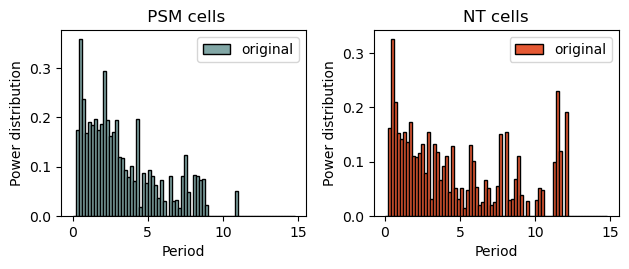

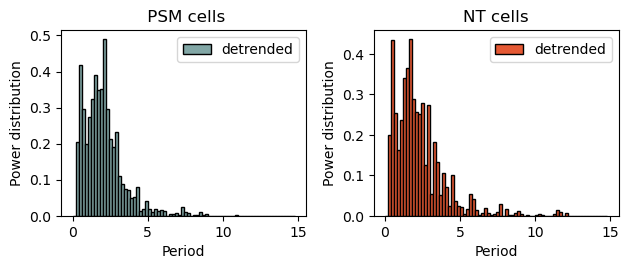

In [46]:
# Plot the histograms

PSM_hist, PSM_bins, PSM_fwhm, PSM_half_max = histogram(period_array_PSM, magnitudes_array_PSM, 'PSM cells')
NT_hist, NT_bins, NT_fwhm, NT_half_max = histogram(period_array_NT, magnitudes_array_NT, 'NT cells')
PSM_detrend_hist, PSM_detrend_bins, PSM_detrend_fwhm, PSM_detrend_half_max = histogram(period_array_PSM_detrend, magnitudes_array_PSM_detrend, 'PSM cells detrended')
NT_detrend_hist, NT_detrend_bins, NT_detrend_fwhm, NT_detrend_half_max = histogram(period_array_NT_detrend, magnitudes_array_NT_detrend, 'NT cells detrended')

plt.figure()
plt.subplot(2,2,1)
plt.bar(PSM_bins[:-1], PSM_hist, width=np.diff(PSM_bins), edgecolor="black", align="edge", label = 'original', color = colour_PSM)
plt.xlabel('Period')
plt.ylabel('Power distribution')
plt.title(' PSM cells')
plt.legend()

plt.subplot(2,2,2)
plt.bar(NT_bins[:-1], NT_hist, width=np.diff(NT_bins), edgecolor="black", align="edge", label = 'original', color = colour_NT)
plt.xlabel('Period')
plt.ylabel('Power distribution')
plt.title('NT cells')
plt.tight_layout()
plt.legend()

plt.figure()
plt.subplot(2,2,3)
plt.bar(PSM_detrend_bins[:-1], PSM_detrend_hist, width=np.diff(PSM_detrend_bins), edgecolor="black", align="edge", label = 'detrended', color= colour_PSM)
plt.xlabel('Period')
plt.ylabel('Power distribution')
plt.title(' PSM cells')
plt.legend()

plt.subplot(2,2,4)
plt.bar(NT_detrend_bins[:-1], NT_detrend_hist, width=np.diff(NT_detrend_bins), edgecolor="black", align="edge", label = 'detrended', color= colour_NT)
plt.xlabel('Period')
plt.ylabel('Power distribution')
plt.title('NT cells')
plt.tight_layout()
plt.legend()

C:\Users\kbmcd\AppData\Local\Temp\ipykernel_9028\2293613247.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_mean = rolling_mean.fillna(method='bfill')
C:\Users\kbmcd\AppData\Local\Temp\ipykernel_9028\2293613247.py:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_mean = rolling_mean.fillna(method='ffill')


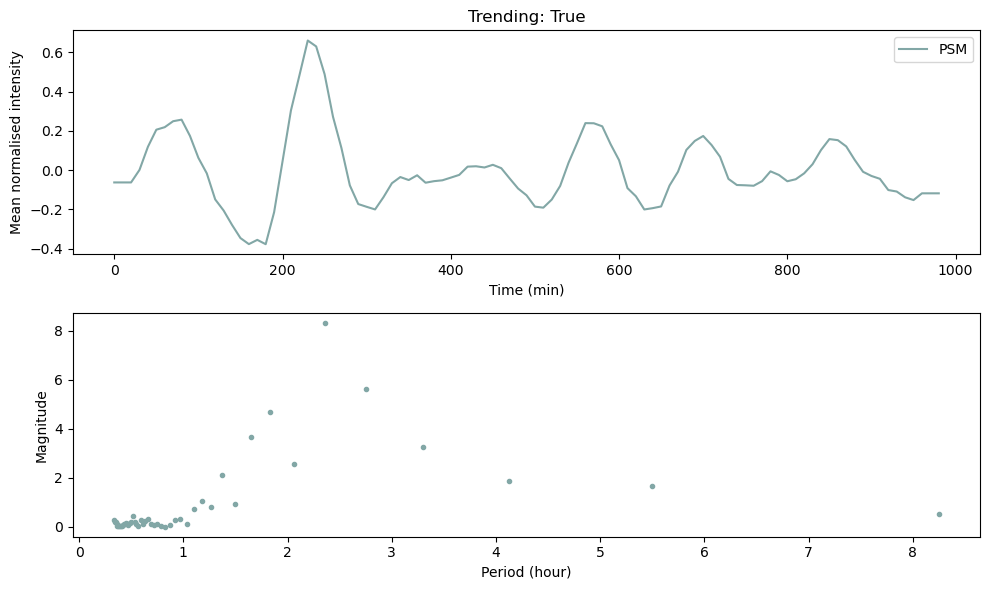

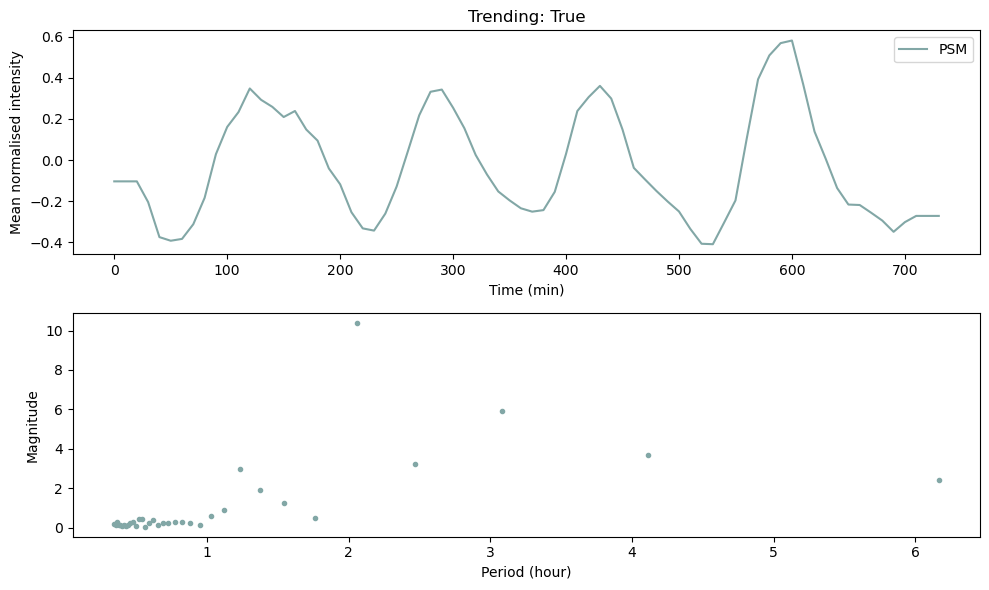

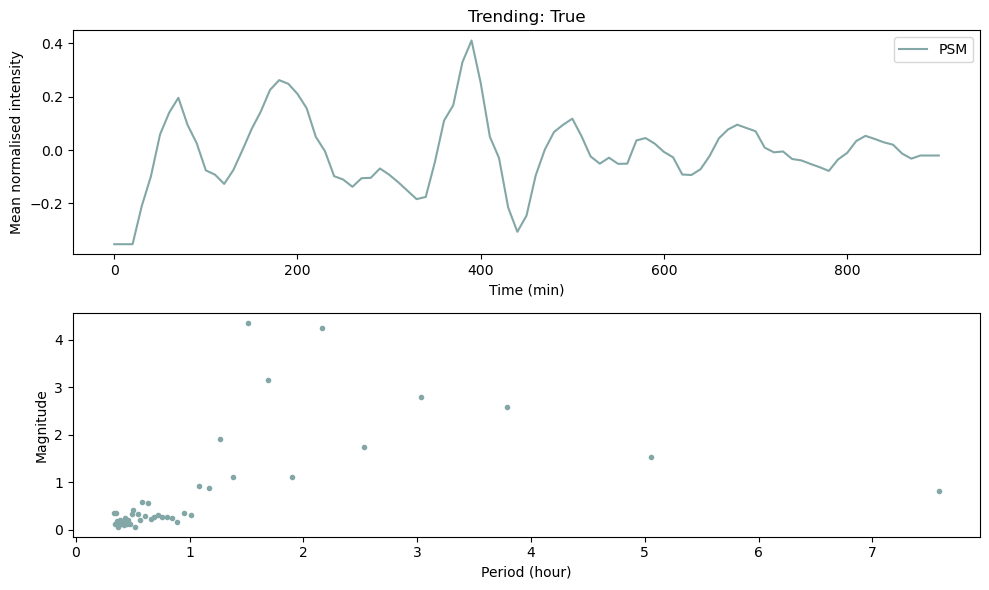

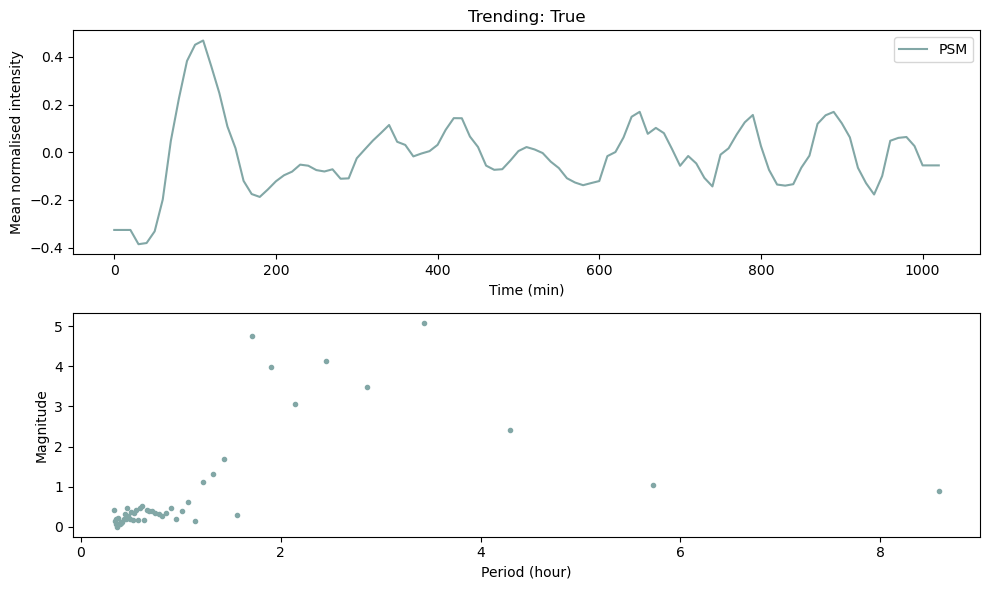

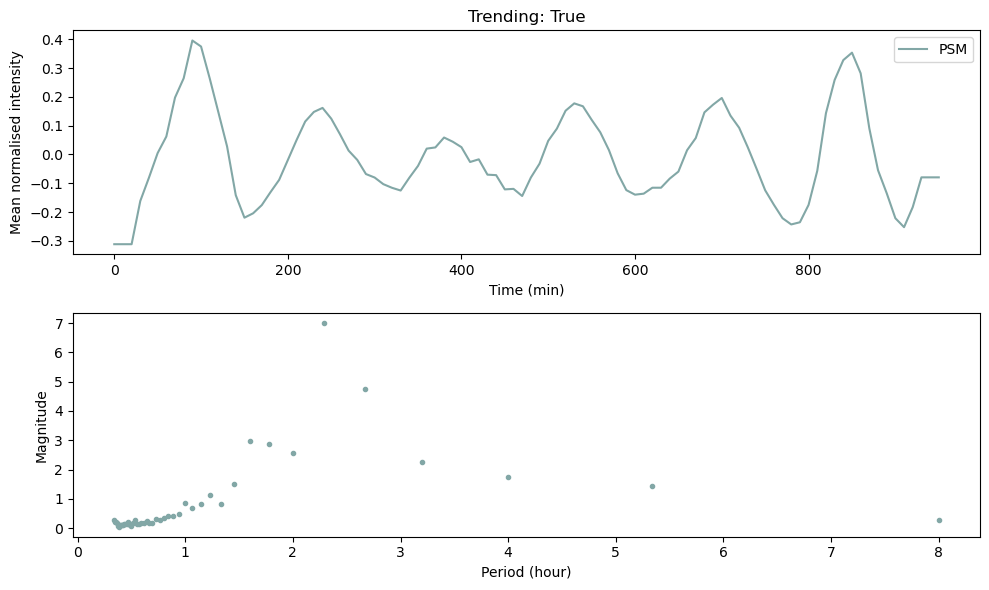

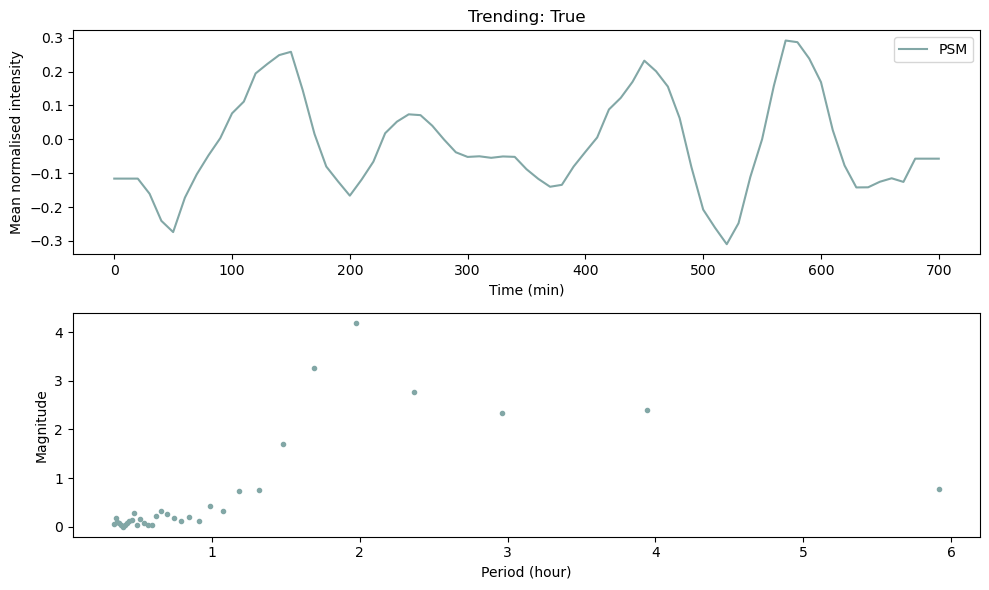

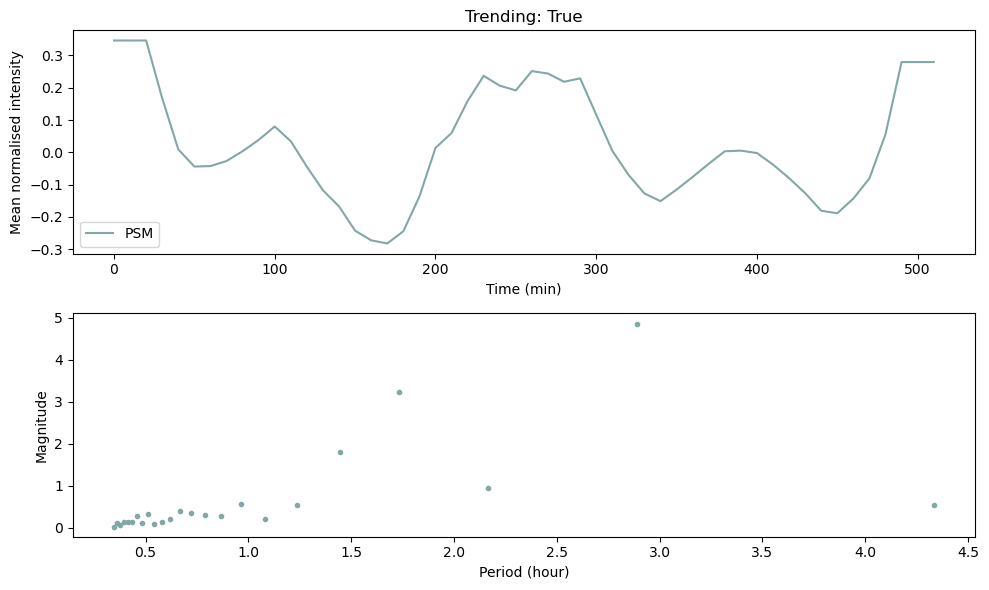

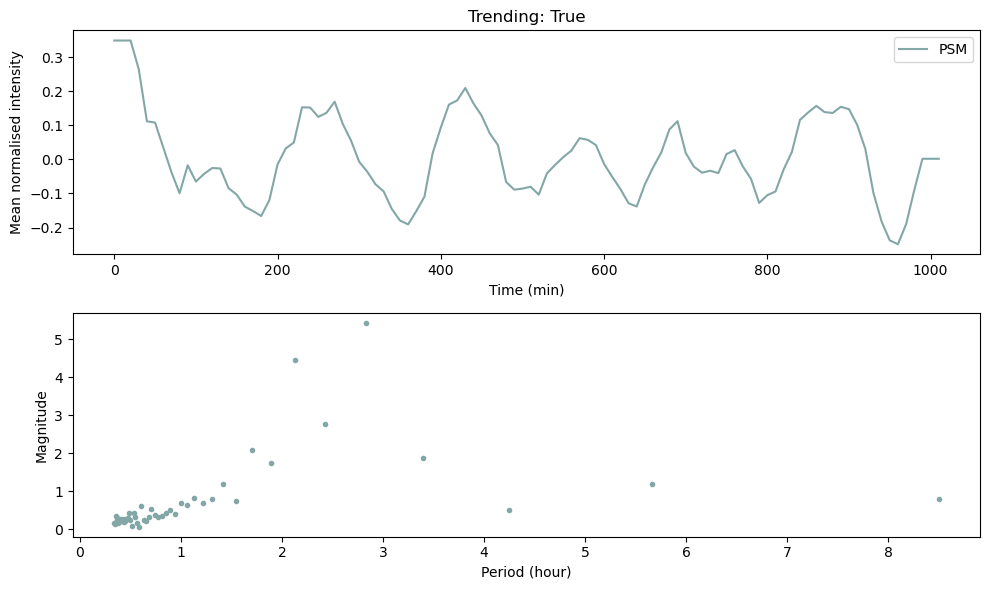

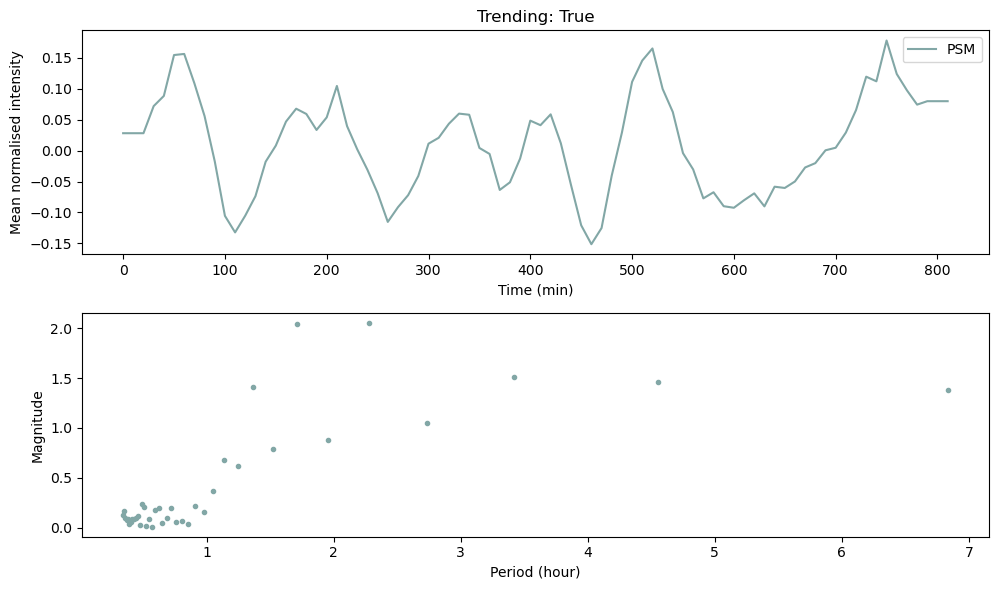

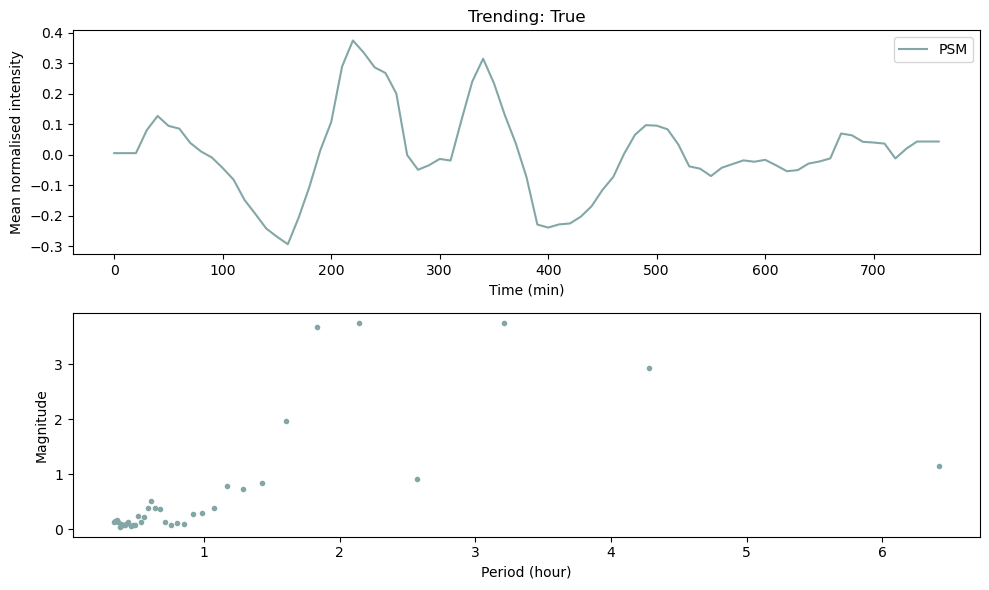

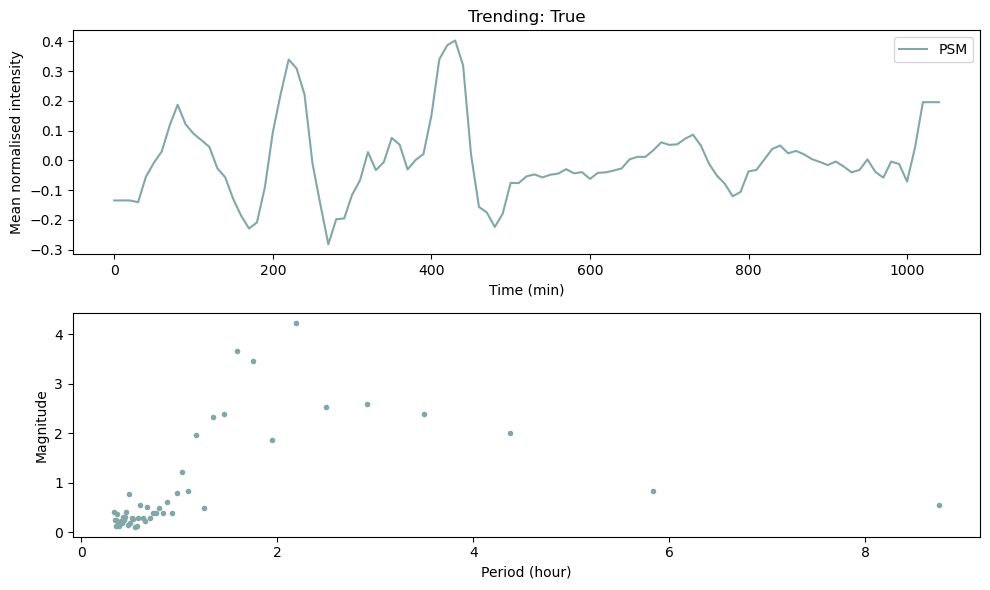

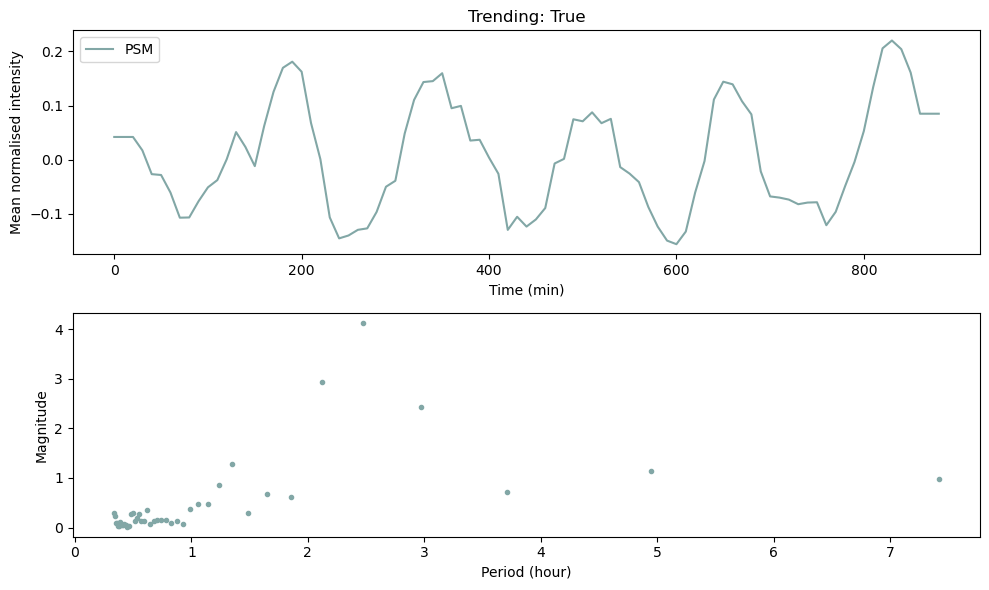

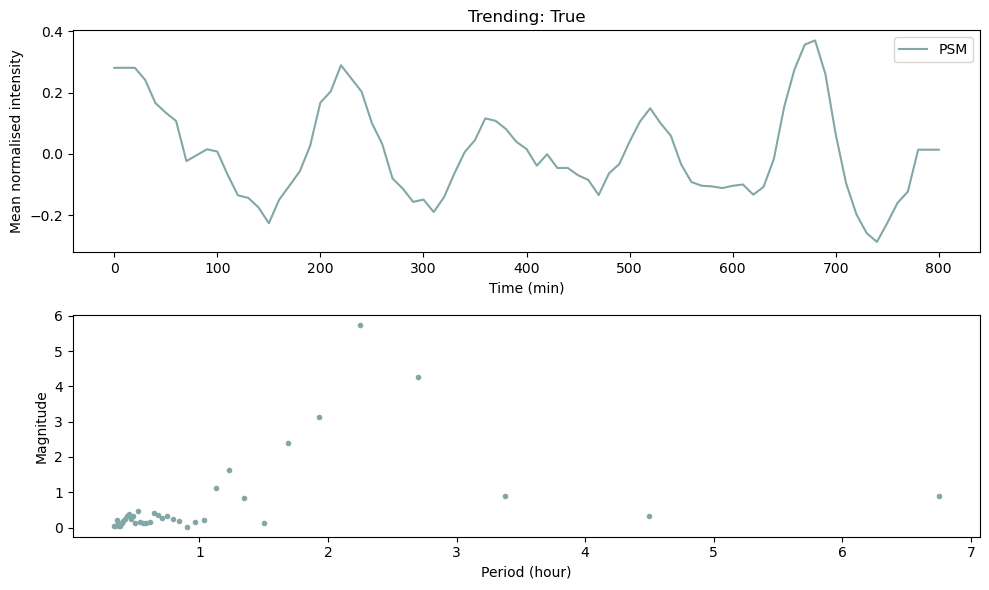

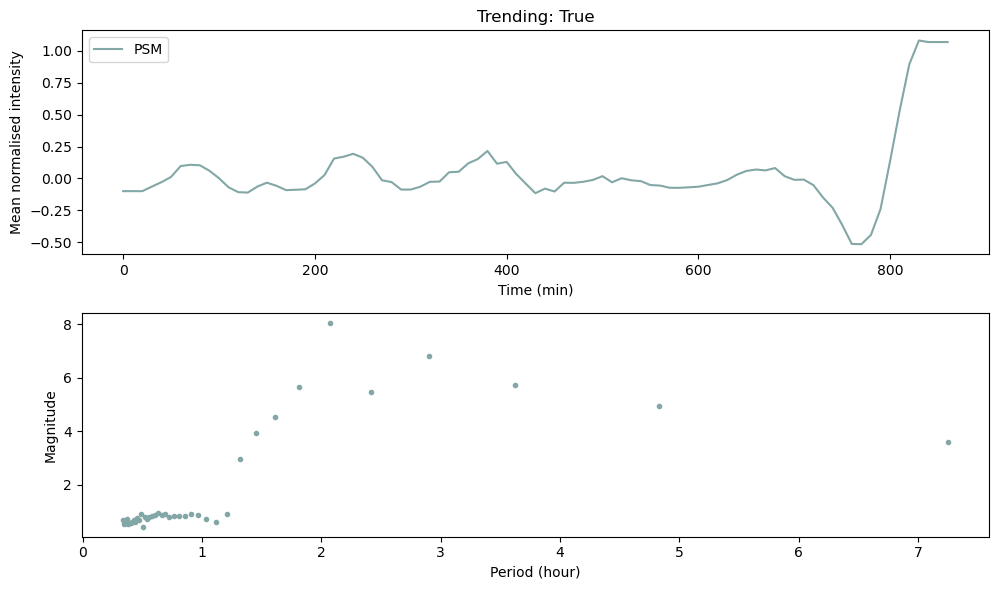

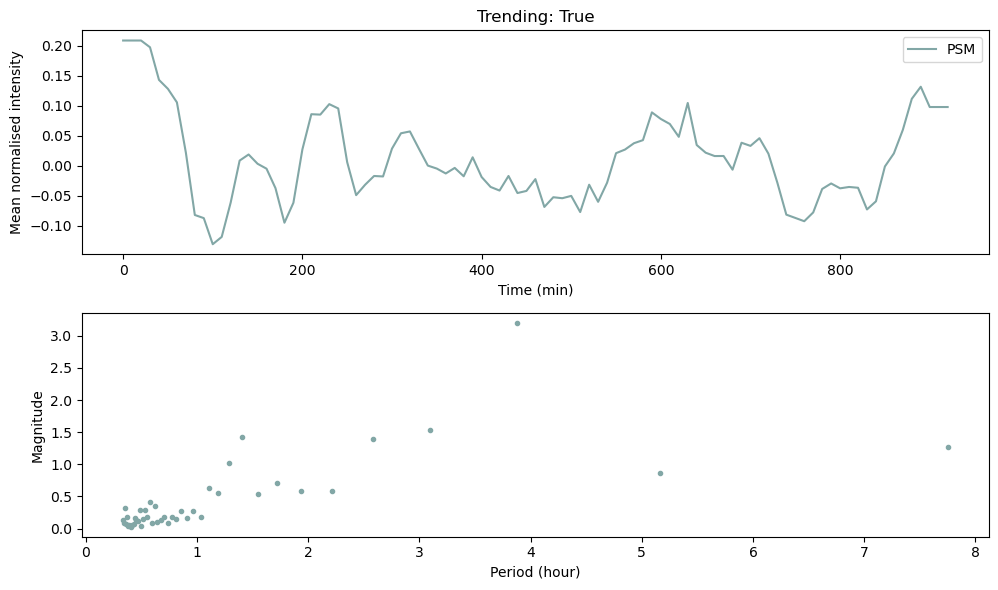

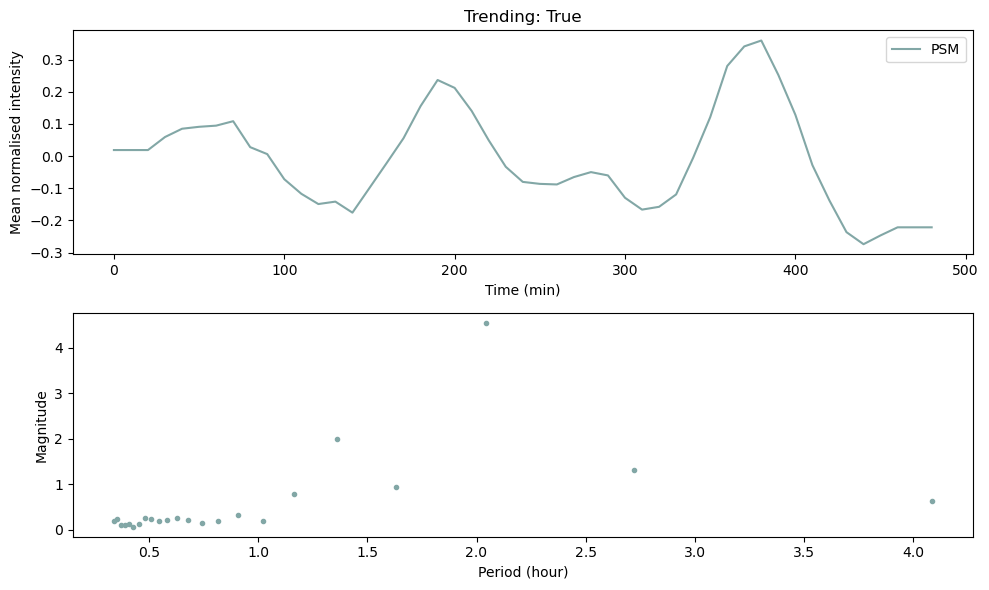

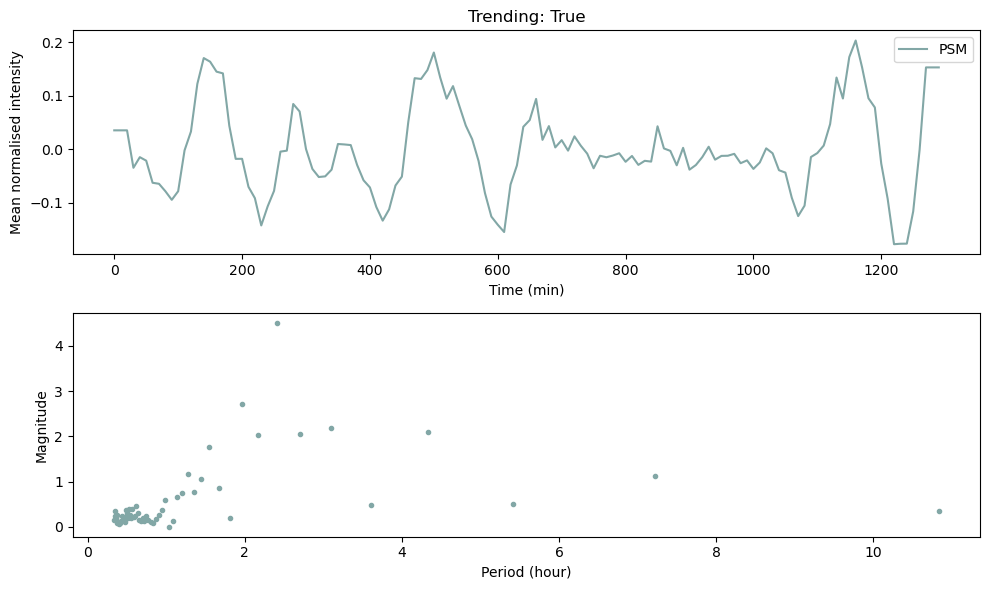

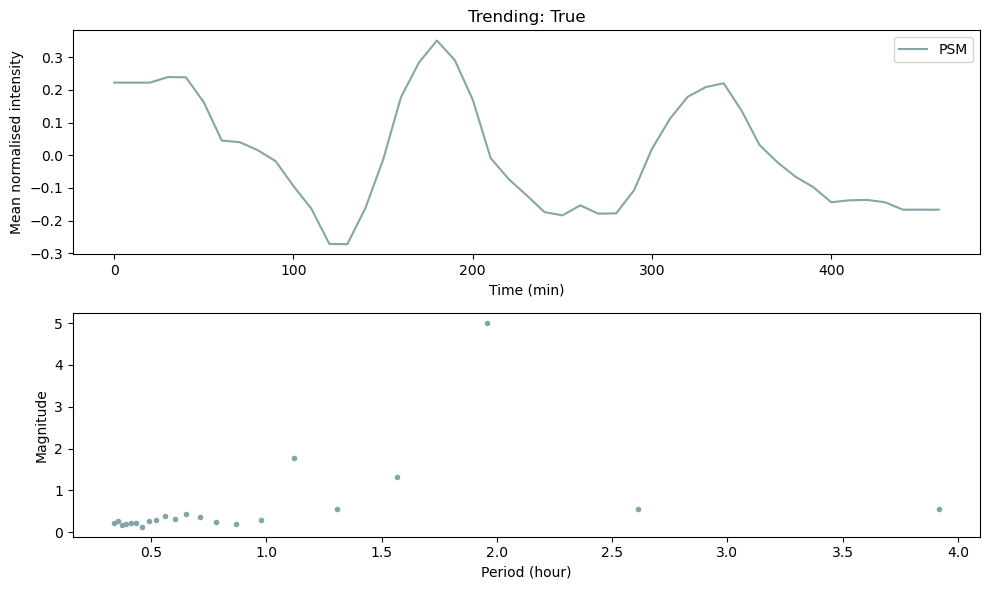

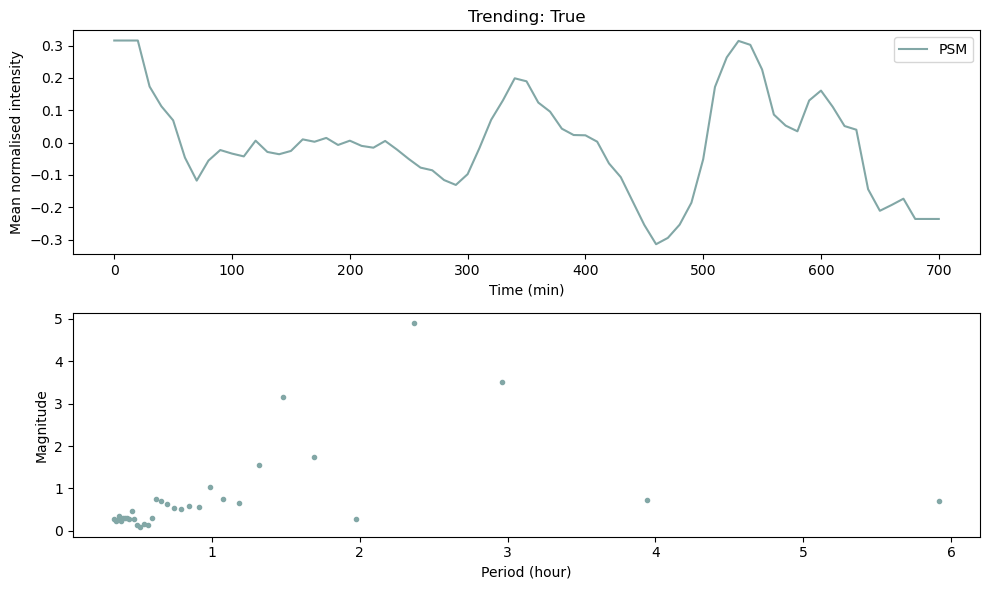

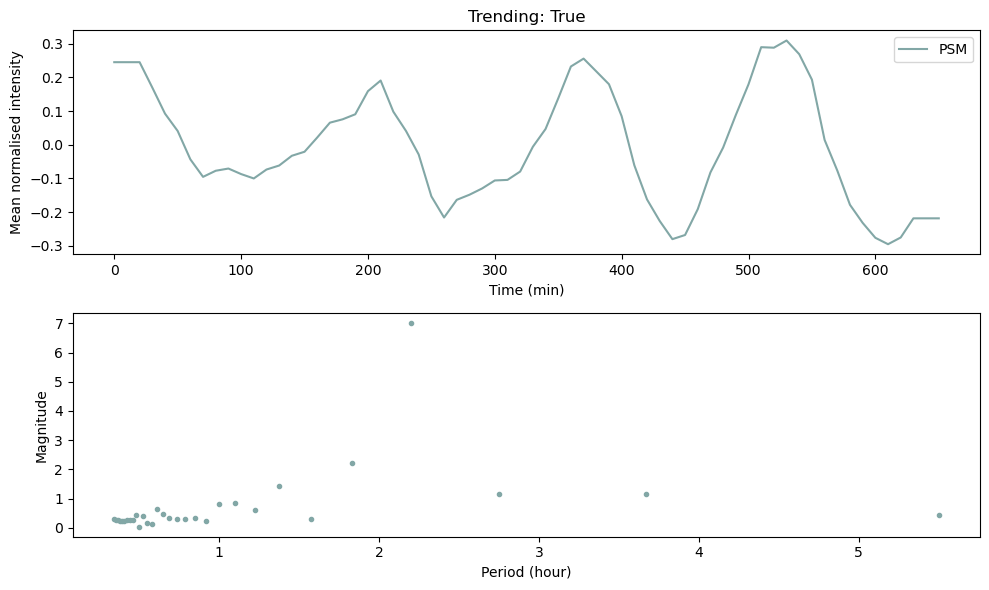

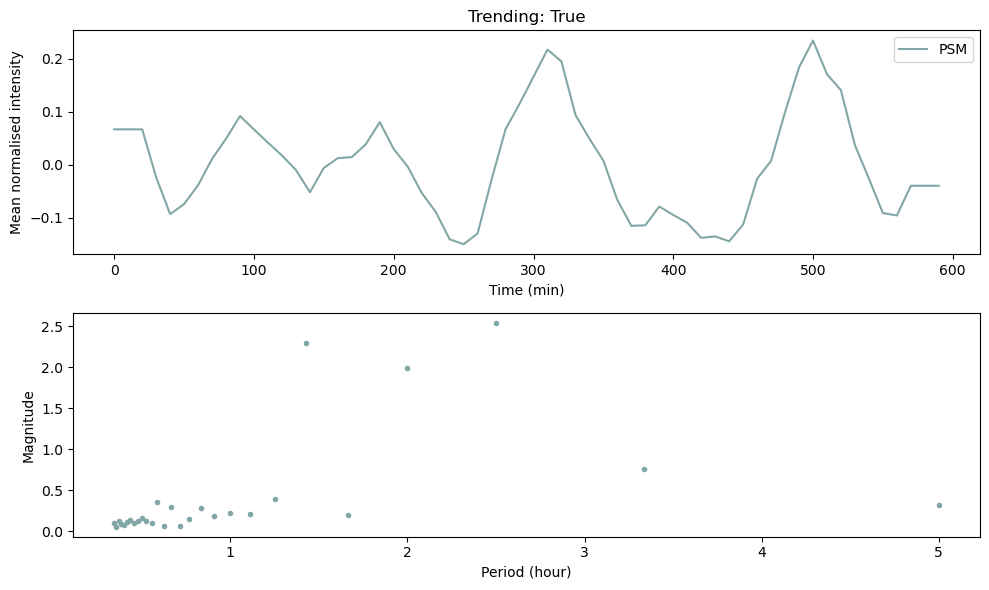

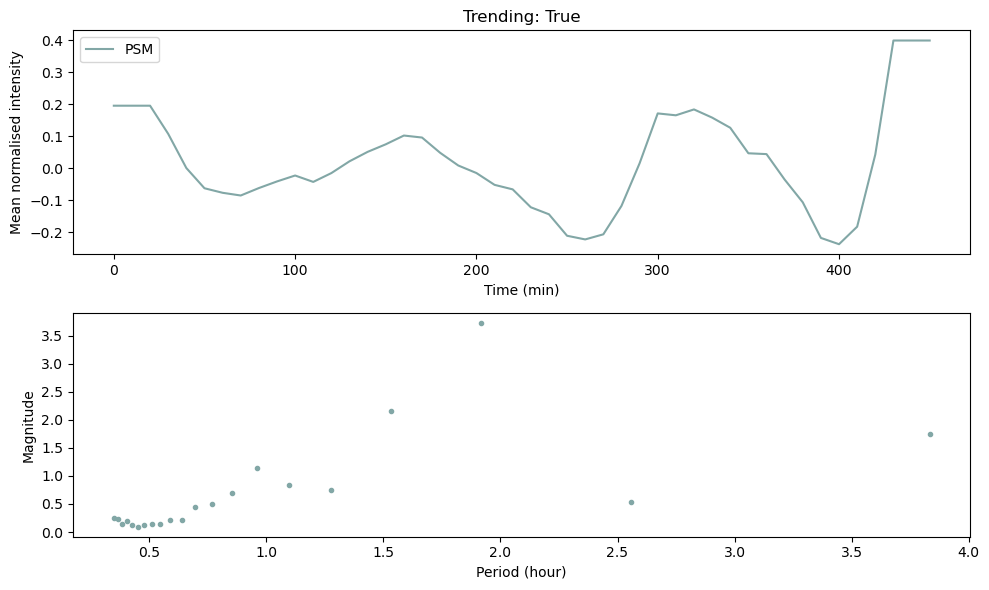

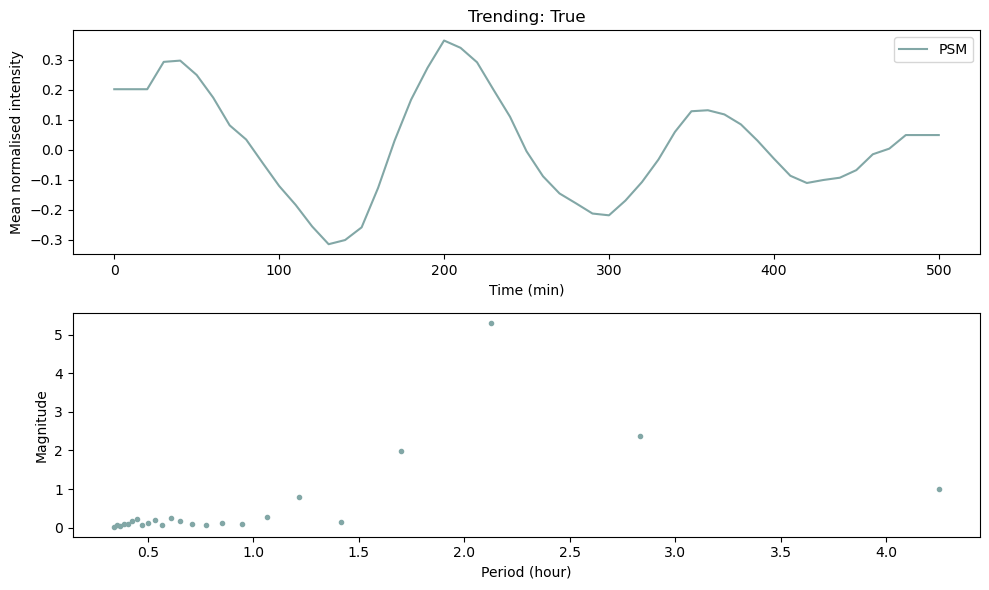

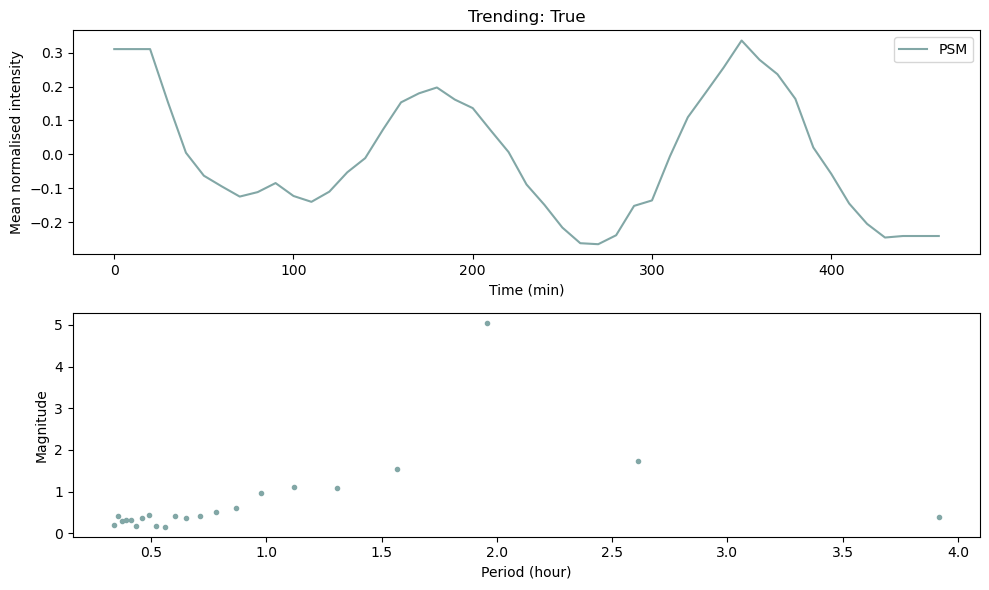

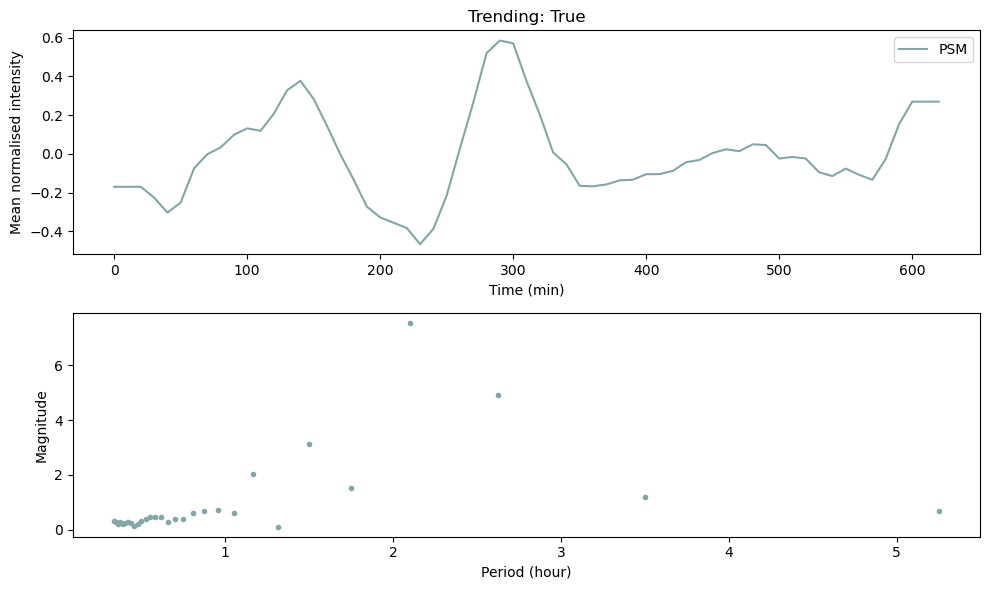

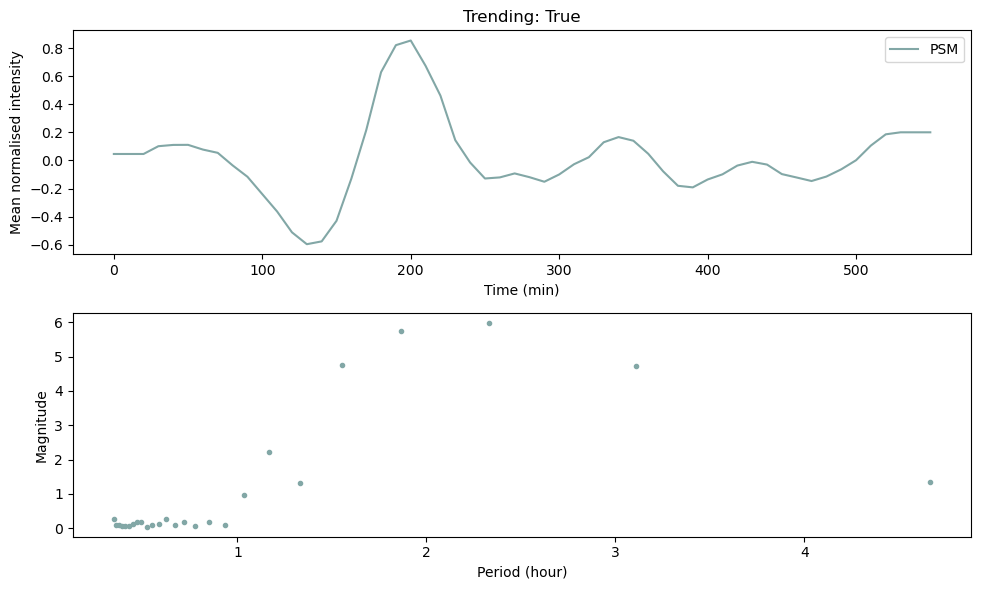

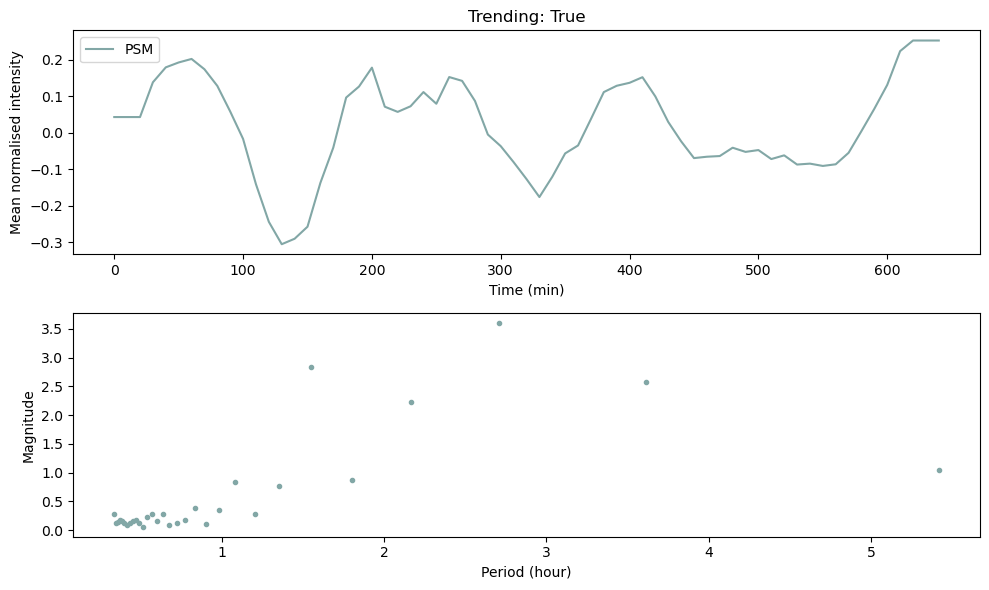

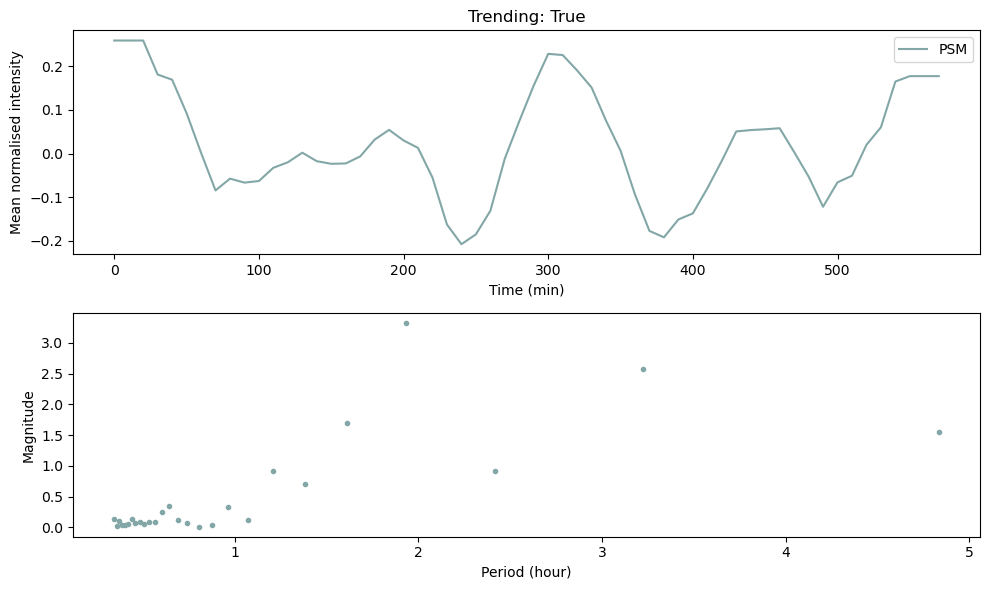

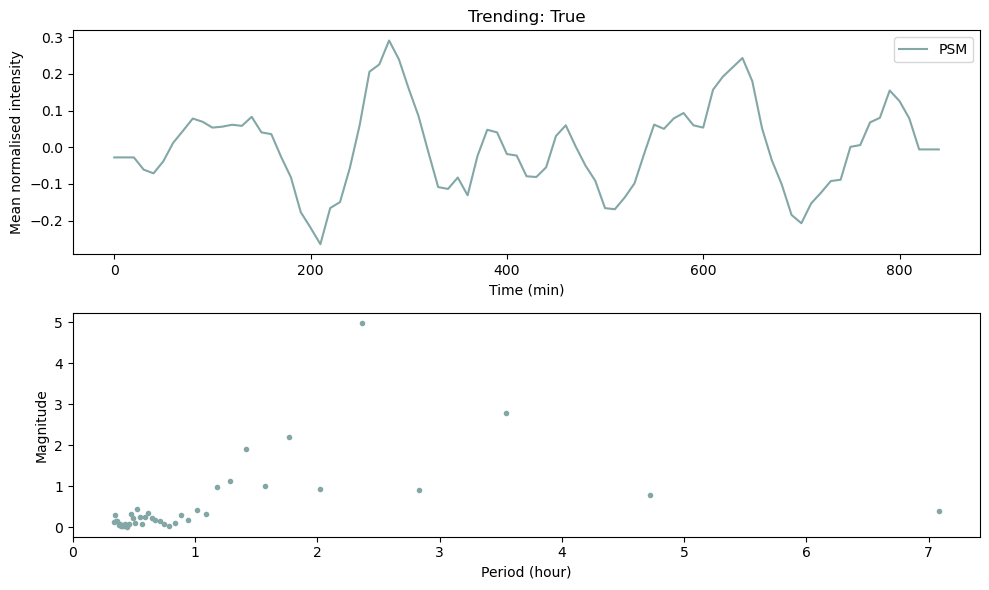

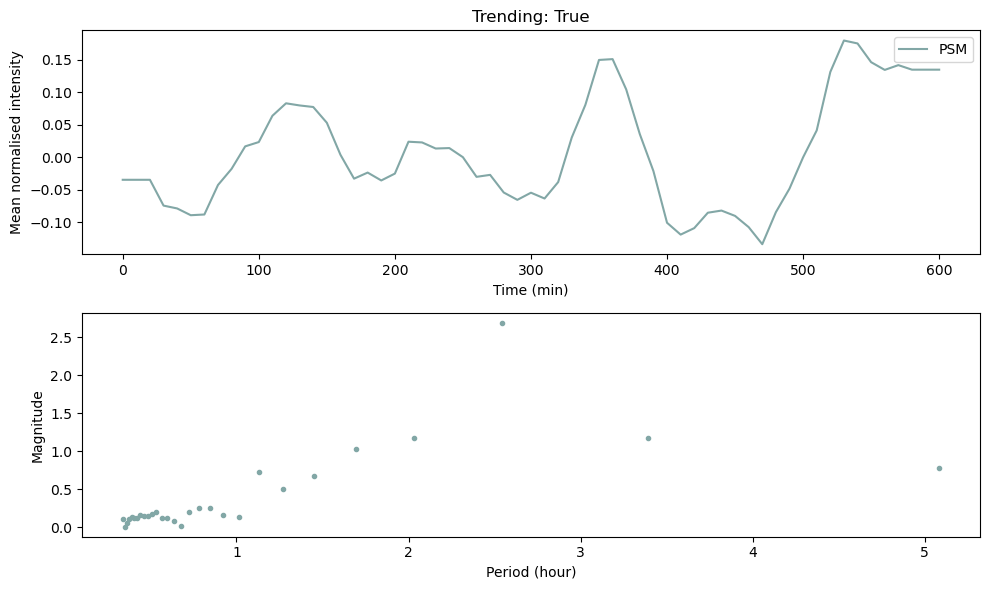

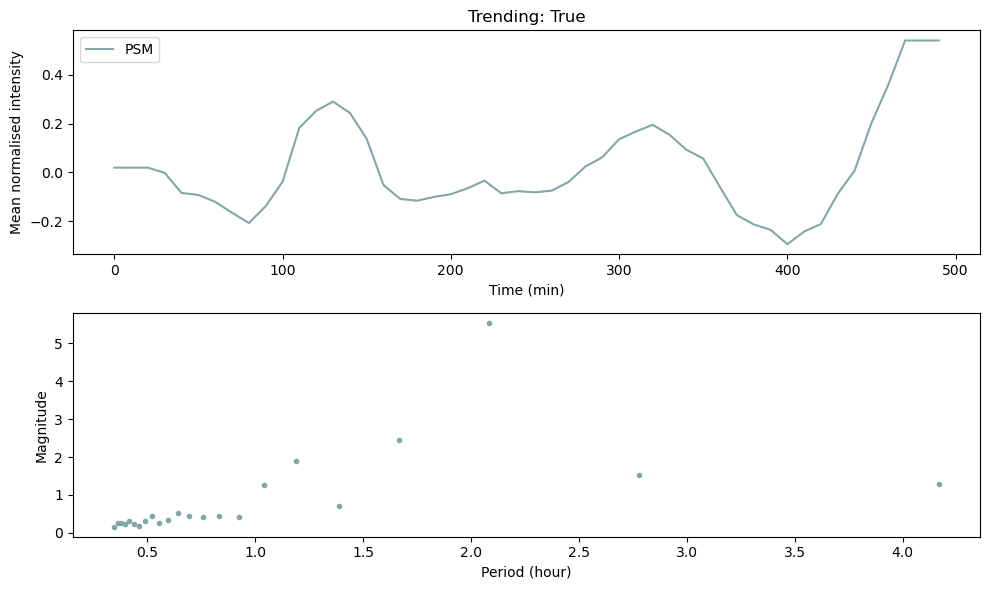

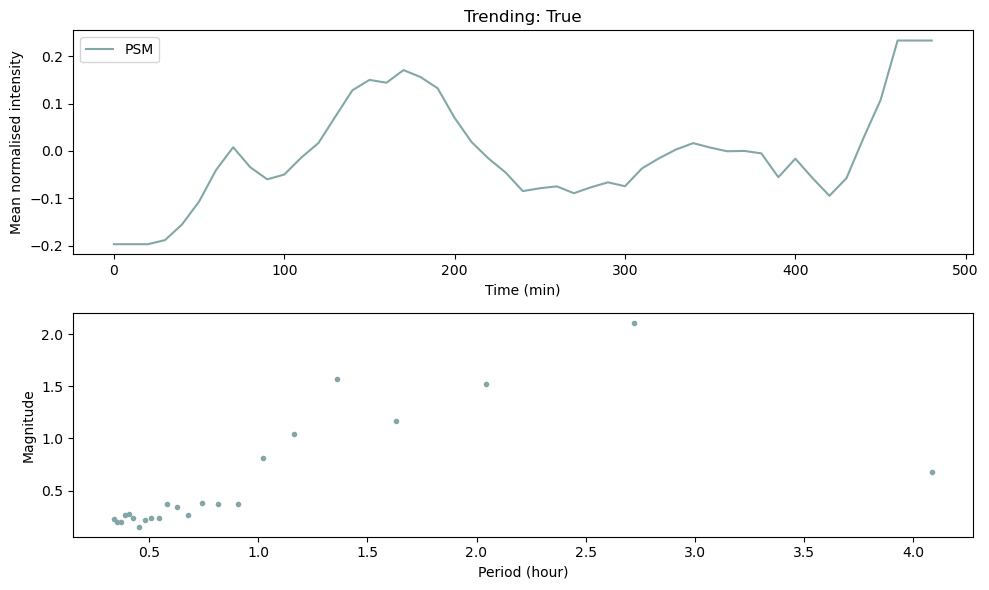

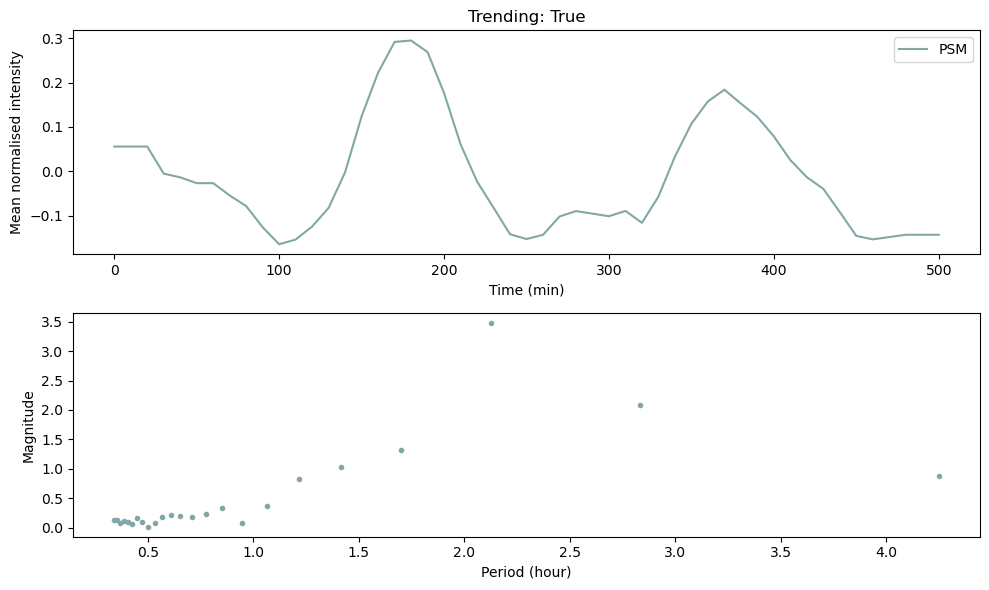

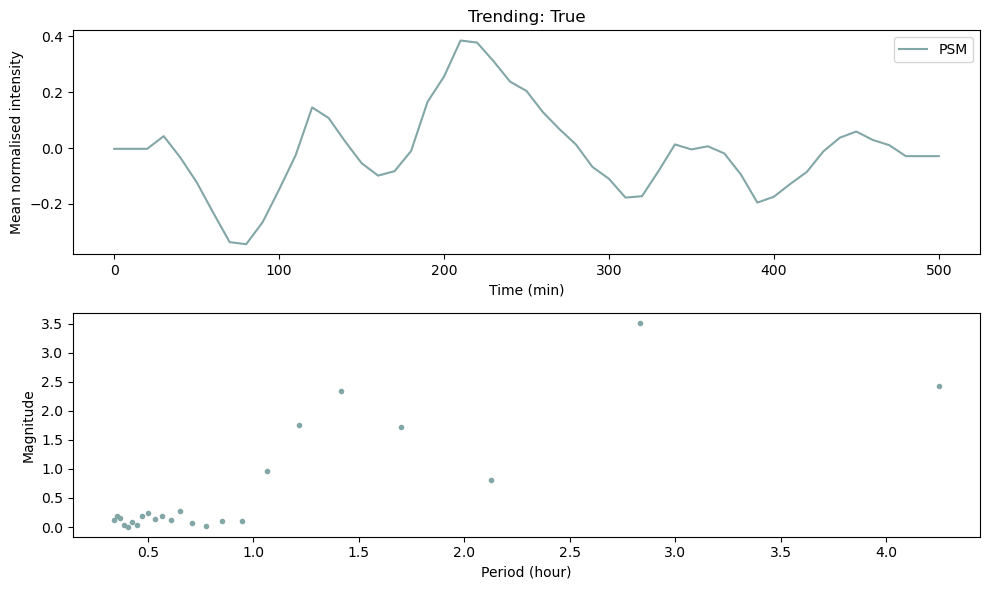

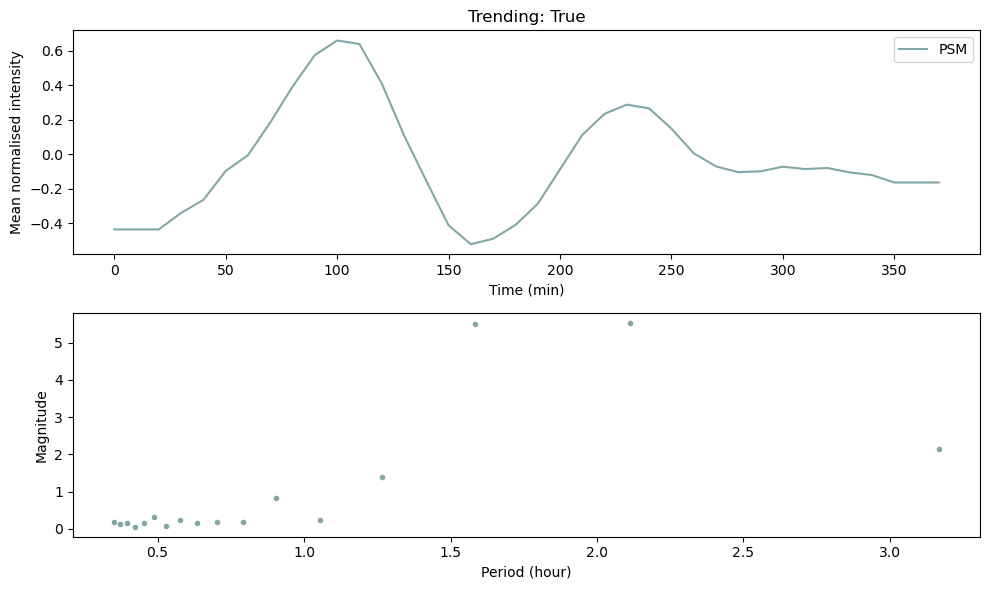

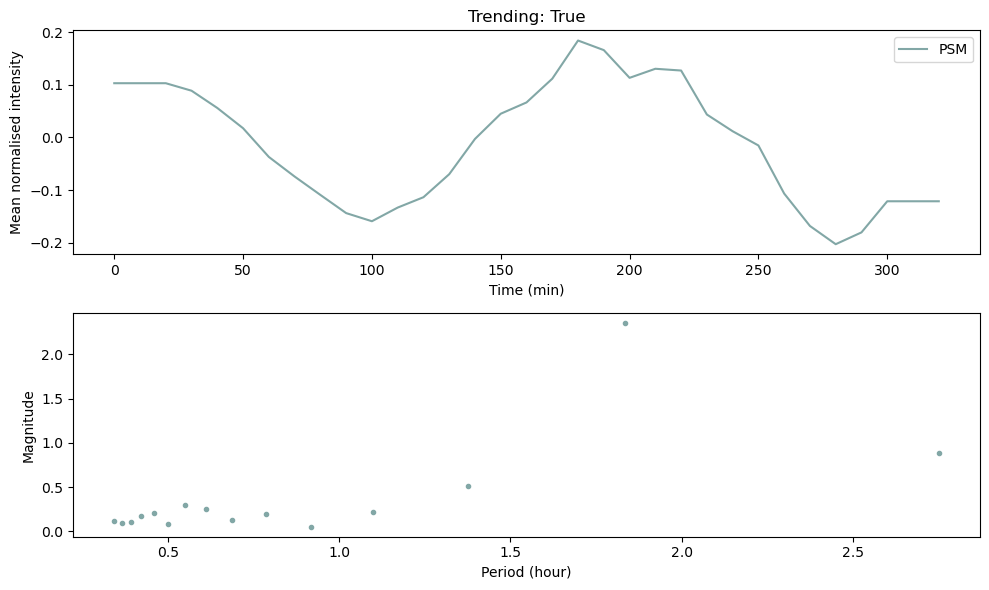

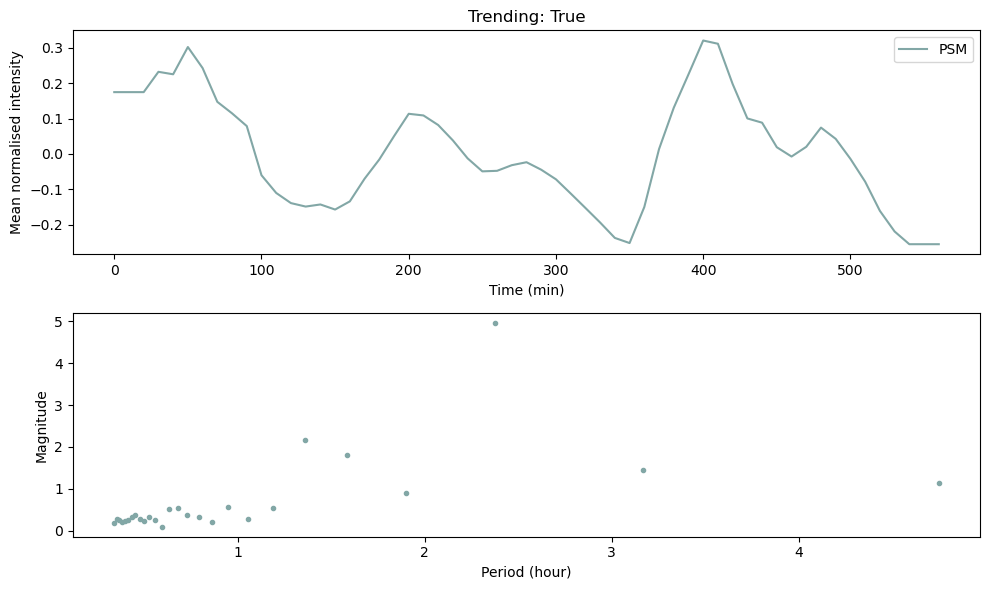

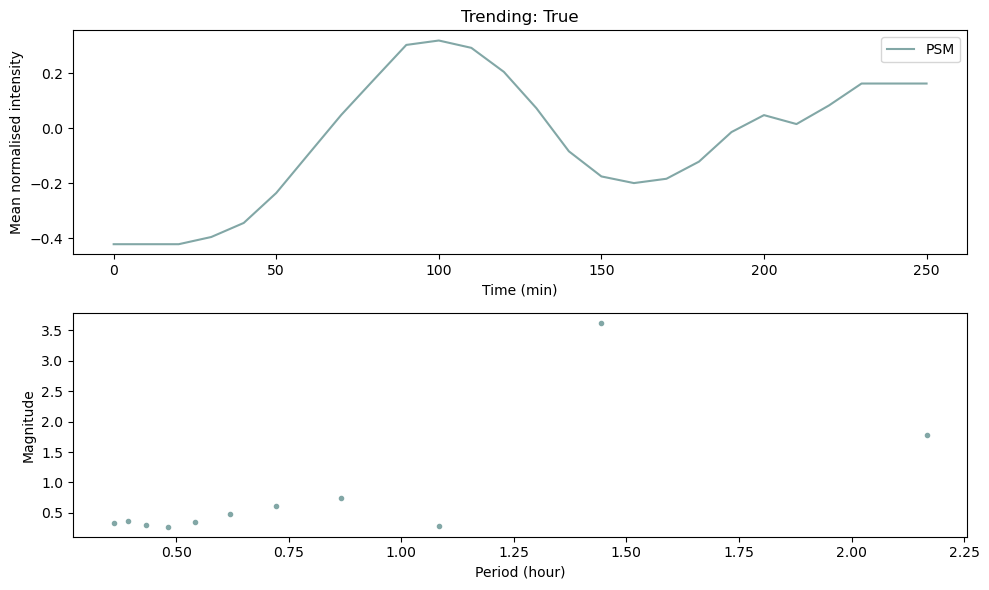

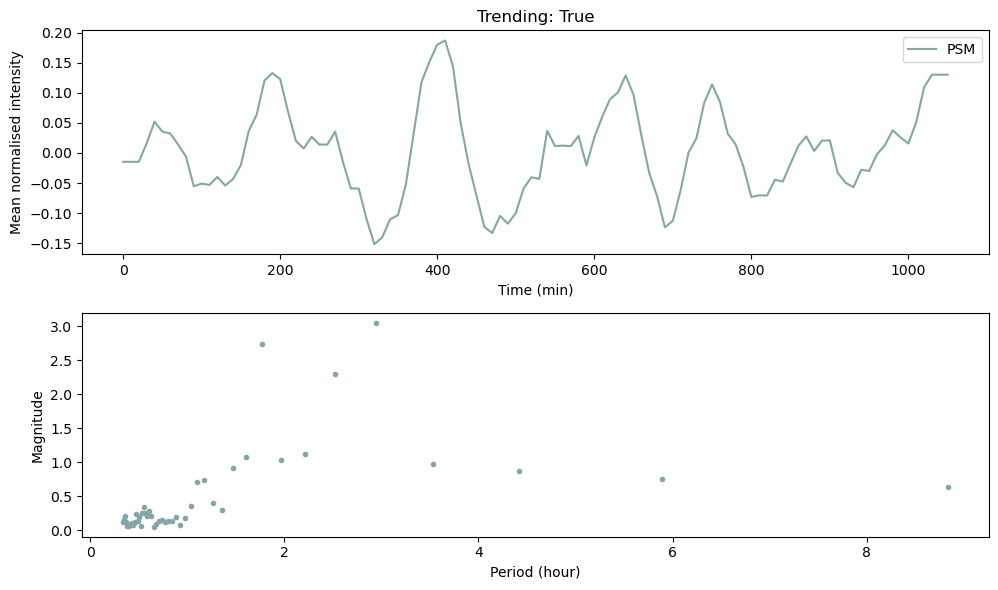

(array([ 78.37973894,  83.95516653,  87.33909101,  89.20591338,
         84.92121796,  89.89383495,  97.31988746,  81.20296861,
         88.00175302,  78.05339002,  83.68094681,  81.35463179,
         86.23638624,  91.10151048,  86.18870241,  81.52913956,
         87.02731122,  95.40488499, 112.28985364,  96.99140299,
        102.196995  ,  89.93241684,  89.05279856,  87.58230402,
         72.21888722,  89.75925393,  86.65579132,  71.8116872 ,
         74.08425463,  67.26397817,  58.41483223,  60.86725144,
         65.84994464,  52.12539674,  49.58797952,  62.3198083 ,
         72.64028022,  68.03571664,  70.18697408,  80.39848411,
         92.14349418,  82.65974379,  76.95658431,  71.15010083,
         61.37469709,  53.63656726,  54.61349521,  53.07290506,
         45.68159724,  53.39236363,  59.50956504,  45.65839728,
         57.45161725,  62.50125242,  62.87532425,  64.07241318,
         83.99968028,  57.72051271,  72.31967319,  73.47362499,
         80.22310339,  72.67004646,  79.

In [23]:
Fourier_bulk('PSM', trending = True, signal_plot = True, period_plot = True, plot_save=True)


## Analysis of trend


C:\Users\kbmcd\AppData\Local\Temp\ipykernel_9028\563891050.py:35: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_mean = rolling_mean.fillna(method='bfill')
C:\Users\kbmcd\AppData\Local\Temp\ipykernel_9028\563891050.py:36: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  rolling_mean = rolling_mean.fillna(method='ffill')


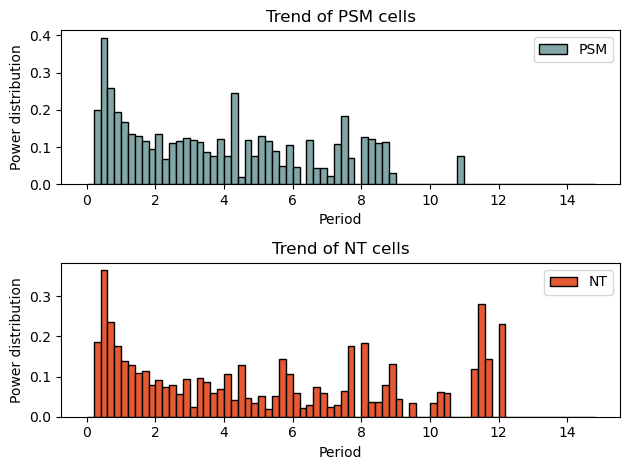

In [56]:
type = 'PSM'

def trend_bulk(type):
    if type == 'PSM':
        data = data_PSM
        index = PSM_index
        color = colour_PSM

    elif type == 'NT':
        data = data_NT
        index = NT_index
        color = colour_NT

    elif type == 'SM':
        data = data_SM
        index = SM_index
        color = colour_SM

    trends = []
    trend_periods = []
    trend_magnitudes = []

    for i in index:
        # extract raw signal from data 
        signal = data[data['Cell ID'] == i]['Spot center intensity Center ch1'].values # Signal converted to array
        
        signal_adapted, period, positive_magnitude, trend, trend_period, trend_magnitude = signal_analysis(signal, trending = True) # Signal analysis like in Ina
        data.loc[data['Cell ID'] == i, 'Detrended spot cnt intensity ch1'] = signal_adapted

        trends.extend(trend)
        trend_periods.extend(trend_period)
        trend_magnitudes.extend(trend_magnitude)

        # # If desired, plot the signal and periodogram
        # plt.figure(figsize=(10, 6))
        # plt.subplot(2,1,1)
        # plt.plot(10*np.arange(len(trend)), trend, label=data[data['Cell ID'] == i]['Label'].values[0], color = color)
        # plt.xlabel('Time (min)')
        # plt.ylabel('Mean normalised intensity')
        # plt.legend()

        # plt.subplot(2,1,2)
        # plt.plot(trend_period, trend_magnitude, marker= '.', linestyle='', color = color)
        # plt.xlabel('Period (hour)')
        # plt.ylabel('Magnitude')
        # plt.tight_layout()  

    trends = np.array(trends)
    trend_periods = np.array(trend_periods)
    trend_magnitudes = np.array(trend_magnitudes)

    return trends, trend_periods, trend_magnitudes

trend_PSM, trend_PSM_periods, trend_PSM_magnitudes = trend_bulk('PSM')
trend_NT, trend_NT_periods, trend_NT_magnitudes = trend_bulk('NT')
trend_SM, trend_SM_periods, trend_SM_magnitudes = trend_bulk('SM')

trend_PSM_hist, trend_PSM_bins, trend_PSM_fwhm, trend_PSM_half_max = histogram(trend_PSM_periods, trend_PSM_magnitudes, 'trend of PSM cells', plot = False)
trend_NT_hist, trend_NT_bins, trend_NT_fwhm, trend_NT_half_max = histogram(trend_NT_periods, trend_NT_magnitudes, 'trend of NT cells', plot = False)

plt.figure()
plt.subplot(2,1,1)
plt.bar(trend_PSM_bins[:-1], trend_PSM_hist, width=np.diff(trend_PSM_bins), edgecolor="black", align="edge", label = 'PSM', color = colour_PSM)
plt.xlabel('Period')
plt.ylabel('Power distribution')
plt.title('Trend of PSM cells')
plt.legend()

plt.subplot(2,1,2)
plt.bar(trend_NT_bins[:-1], trend_NT_hist, width=np.diff(trend_NT_bins), edgecolor="black", align="edge", label = 'NT', color = colour_NT)
plt.xlabel('Period')
plt.ylabel('Power distribution')
plt.title('Trend of NT cells')
plt.tight_layout()
plt.legend()




## Movement of cells

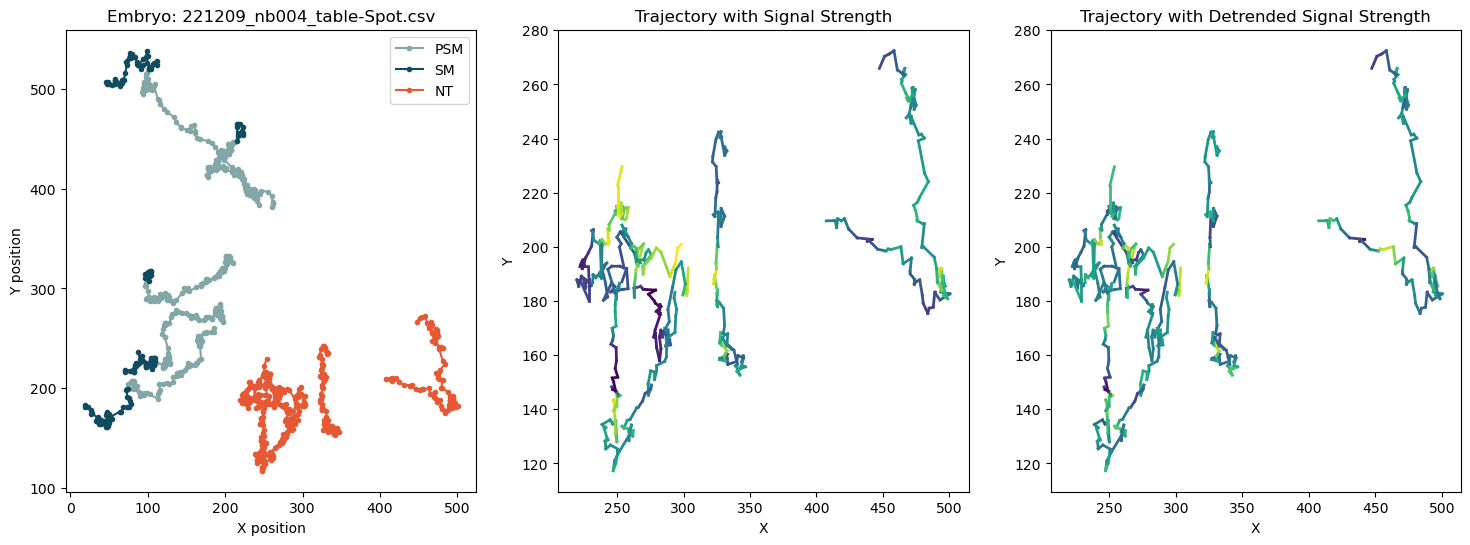

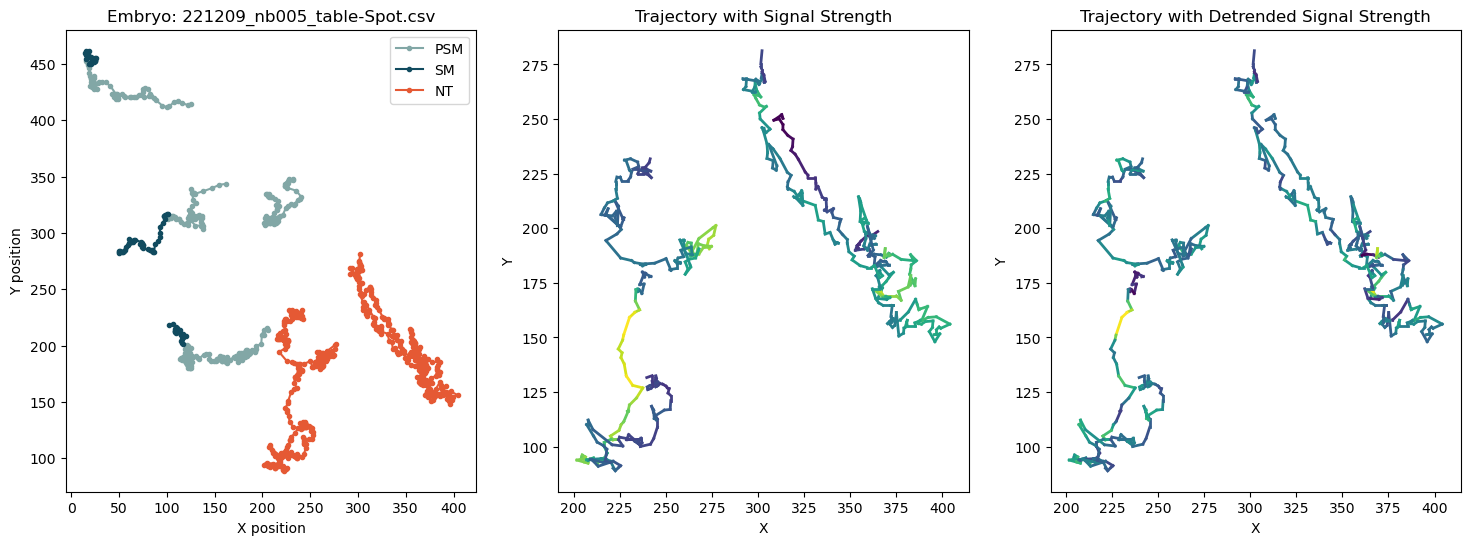

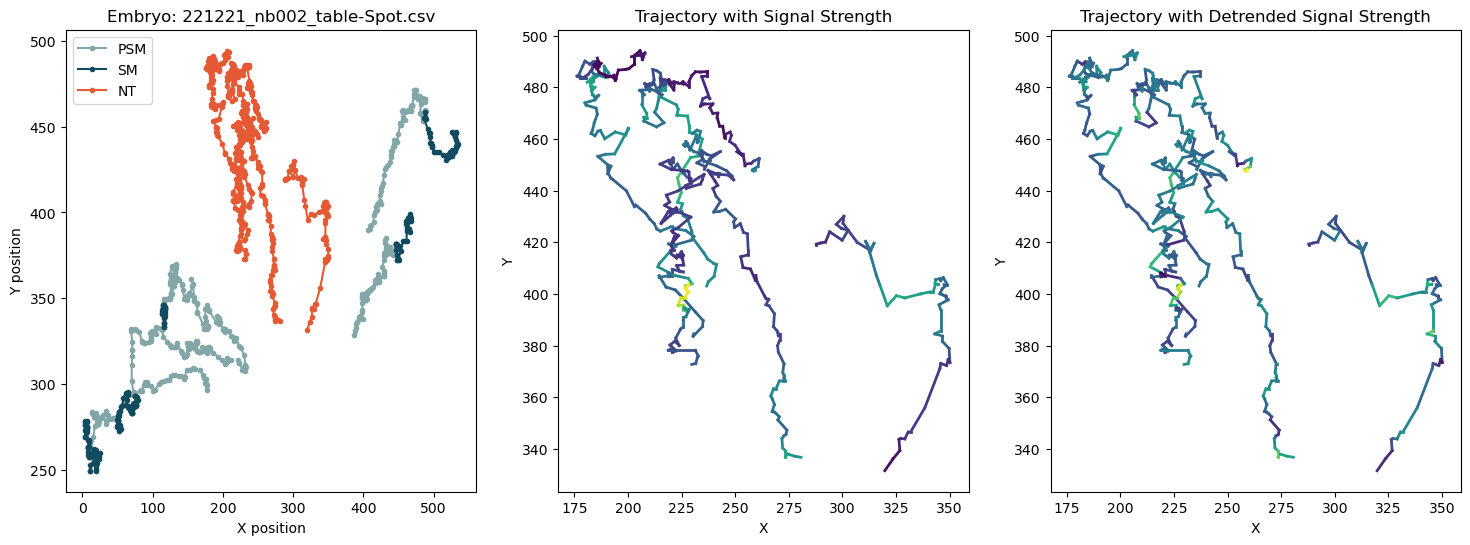

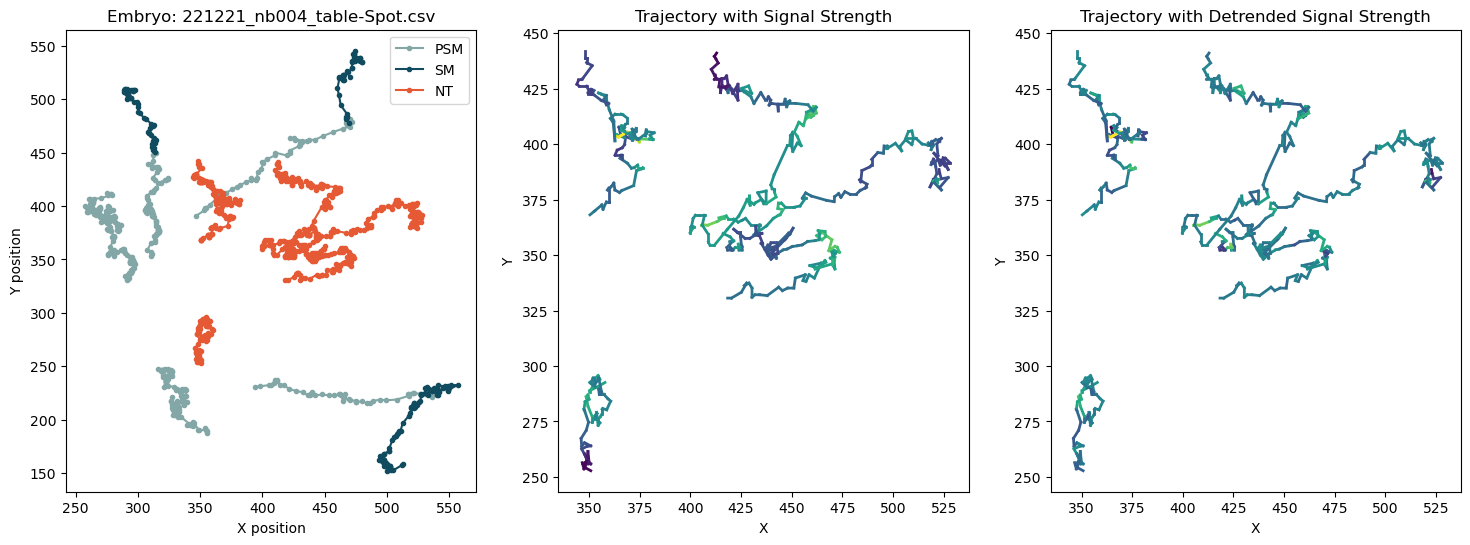

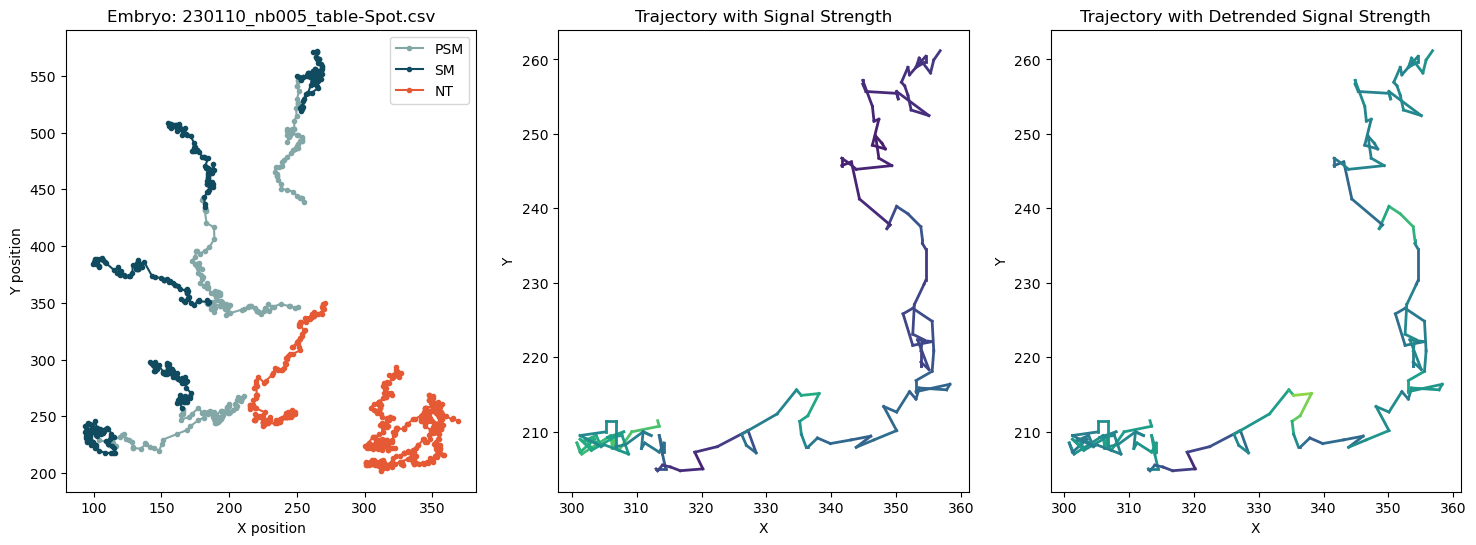

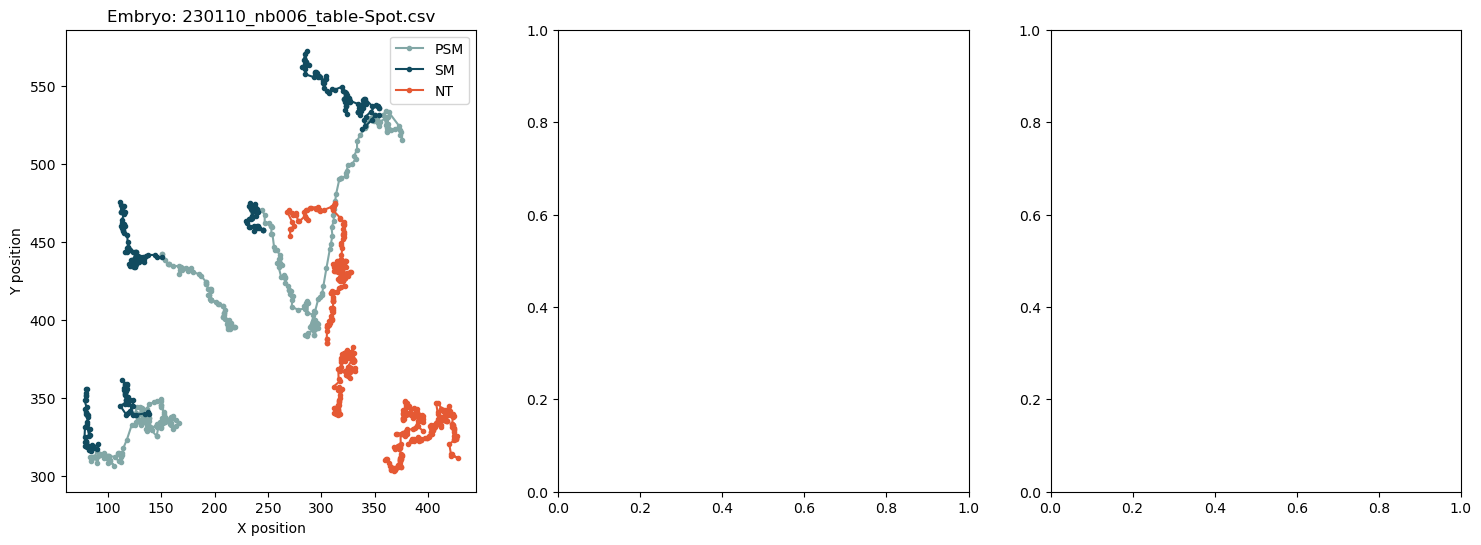

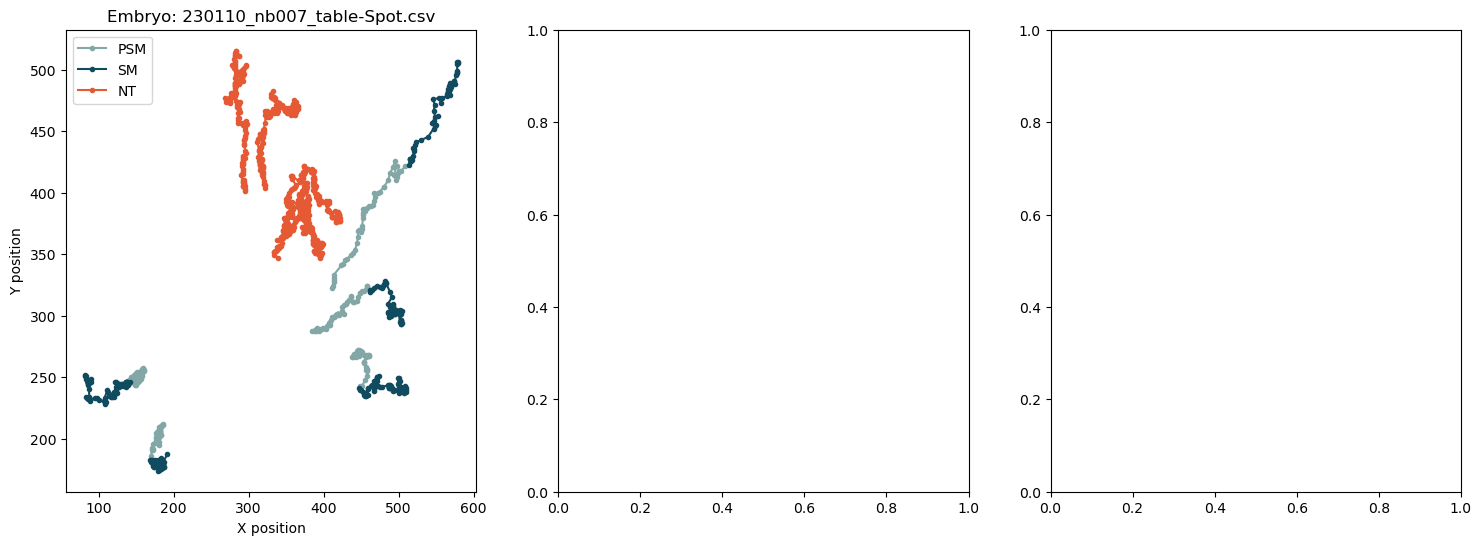

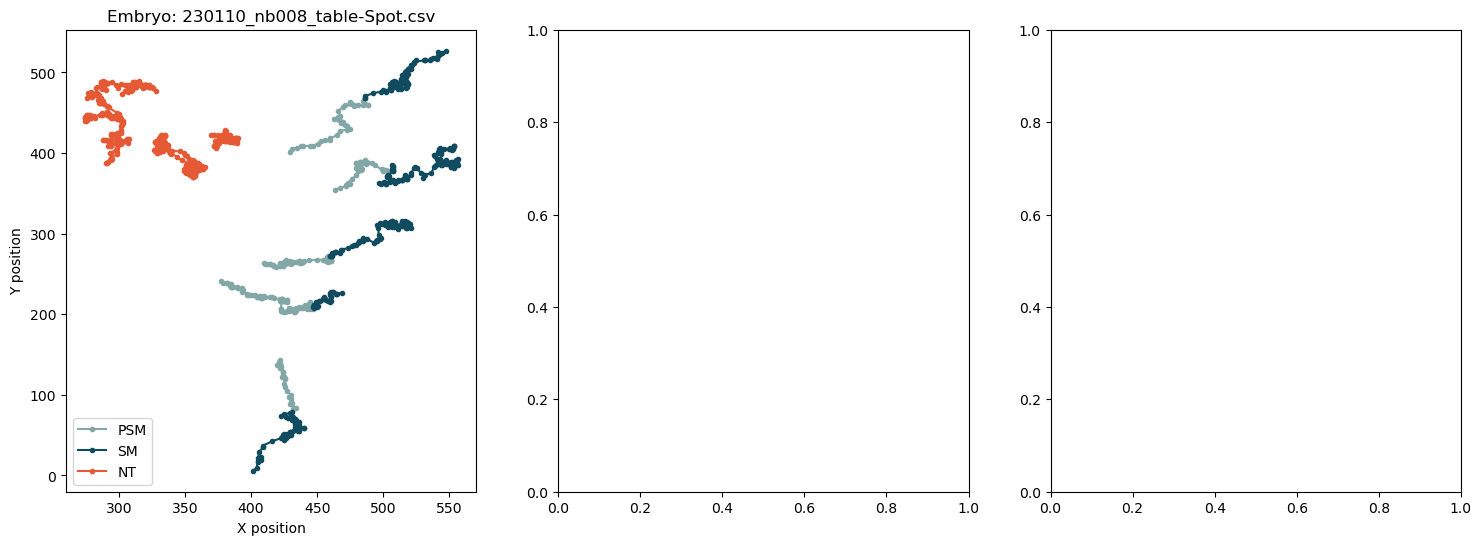

In [58]:
file_list = data['source_file'].unique()
for set in range(len(file_list)):

    all_signals = data[data['source_file'] == file_list[set]]['Smoothened spot cnt intensity ch1'].values
    all_signals_detrend = data[data['source_file'] == file_list[set]]['Detrended spot cnt intensity ch1'].values
    
    norm = Normalize(vmin=np.min(all_signals), vmax=np.max(all_signals))
    norm_detrend = Normalize(vmin=np.min(all_signals_detrend), vmax=np.max(all_signals_detrend))
    cmap = plt.get_cmap('viridis')
    plt.figure(figsize=(18,6))

    plt.subplot(1,3,1)
    for i in PSM_index:
        x_PSM = data_PSM[(data_PSM['Cell ID'] == i) & (data_PSM['source_file'] == file_list[set])]['Spot position X'].values
        y_PSM = data_PSM[(data_PSM['Cell ID'] == i) & (data_PSM['source_file'] == file_list[set])]['Spot position Y'].values

        if i == PSM_index[0]:
            plt.plot(x_PSM, y_PSM, marker='.', linestyle='-', color = colour_PSM, label = 'PSM')
        else:
            plt.plot(x_PSM, y_PSM, marker='.', linestyle='-', color = colour_PSM)

    for i in SM_index:
        x_SM = data_SM[(data_SM['Cell ID'] == i) & (data_SM['source_file'] == file_list[set])]['Spot position X'].values
        y_SM = data_SM[(data_SM['Cell ID'] == i) & (data_SM['source_file'] == file_list[set])]['Spot position Y'].values

        if i == SM_index[0]:
            plt.plot(x_SM, y_SM, marker='.', linestyle='-', color = colour_SM, label = 'SM')
        else:
            plt.plot(x_SM, y_SM, marker='.', linestyle='-', color = colour_SM)
    
    for i in NT_index:
        x_NT = data_NT[(data_NT['Cell ID'] == i) & (data_NT['source_file'] == file_list[set])]['Spot position X'].values
        y_NT = data_NT[(data_NT['Cell ID'] == i) & (data_NT['source_file'] == file_list[set])]['Spot position Y'].values

        if i == NT_index[0]:
            plt.plot(x_NT, y_NT, marker='.', linestyle='-', color = colour_NT, label = 'NT')
        else:
            plt.plot(x_NT, y_NT, marker='.', linestyle='-', color = colour_NT)

    plt.title(f'Embryo: {file_list[set]}')
    plt.xlabel('X position')
    plt.ylabel('Y position')
    plt.legend()

    
    plt.subplot(1,3,2)
    # Normalize the signal for color mapping
    for i in range(len(data['Cell ID'].unique())):
        signal = data[(data['Cell ID'] == i) & (data['source_file'] == file_list[set])]['Smoothened spot cnt intensity ch1'].values
        x_position = data[(data['Cell ID'] == i) & (data['source_file'] == file_list[set])]['Spot position X'].values
        y_position = data[(data['Cell ID'] == i) & (data['source_file'] == file_list[set])]['Spot position Y'].values

        if len(signal) == 0:
            continue
        else:

            # Plot each segment with a color corresponding to the signal value
            
            for i in range(len(x_position) - 1):
                plt.plot(x_position[i:i+2], y_position[i:i+2], color=cmap(norm(signal[i])), linewidth=2)

            # Add a color bar
            sm = ScalarMappable(cmap=cmap, norm=norm)
            sm.set_array([])  # Dummy array for the color bar
            #plt.colorbar(sm, axes=,label='Signal Strength')

            # Add labels and title
            plt.title("Trajectory with Signal Strength")
            plt.xlabel("X")
            plt.ylabel("Y")

    plt.subplot(1,3,3)
    # Normalize the signal for color mapping
    for i in range(len(data['Cell ID'].unique())):
        signal_detrend = data[(data['Cell ID'] == i) & (data['source_file'] == file_list[set])]['Detrended spot cnt intensity ch1'].values
        x_position = data[(data['Cell ID'] == i) & (data['source_file'] == file_list[set])]['Spot position X'].values
        y_position = data[(data['Cell ID'] == i) & (data['source_file'] == file_list[set])]['Spot position Y'].values

        if len(signal_detrend) == 0:
            continue
        else:

            # Plot each segment with a color corresponding to the signal value
            
            for i in range(len(x_position) - 1):
                plt.plot(x_position[i:i+2], y_position[i:i+2], color=cmap(norm_detrend(signal_detrend[i])), linewidth=2)

            # Add a color bar
            sm = ScalarMappable(cmap=cmap, norm=norm_detrend)
            sm.set_array([])  # Dummy array for the color bar
            #plt.colorbar(sm, axes=,label='Signal Strength')

            # Add labels and title
            plt.title("Trajectory with Detrended Signal Strength")
            plt.xlabel("X")
            plt.ylabel("Y")